# Coursework 1 - Supervised Learning

__Name__: Georgios Alevras <br> __CID__: 01531221 <br> __Date__: 23/02/2022

<a name="outline"></a>

## Outline

- [Preliminaries](#preliminaries): Exploratory Data Analysis
- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear Regression
  - [1.2](#q12) Ridge Regression
  - [1.3](#q13) Relaxation of Lasso Regression
- [Task 2](#task-2): Classification
  - [2.1](#q21) k-NN Classifier
  - [2.2](#q22) Random Forest 
  - [2.3](#q23) Support Vector Machine (SVM) 
- [Task 3](#task-3): Mastery Component 
  - [3.1](#q31) Logistic Regression and Bagging 
  - [3.2](#q32) Kernelised SVM Classifier 

<a name="preliminaries"></a>
# Preliminaries: Exploratory Data Analysis [^](#outline)

<br> Firstly, we import all the necessary Python packages to perform and execute all calculations and computations.

In [1]:
# All packages used in this coursework are imported here.
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

We then import the dataset found in `./Data/chemistry_samples.csv` using the pandas package, and inspect it, printing the first 5 rows.

In [2]:
# Loading the sample data set using the pandas read_csv method into a pandas DataFrame.
df_chemistry_samples = pd.read_csv('./Data/chemistry_samples.csv')
# Outputing the first 5 samples (rows) to inspect the data.
df_chemistry_samples.head()

CIC0  SM1_Dz(Z)    GATS1i     NdsCH     NdssC     MLOGP        FV1  \
0  3.661280   0.658363  1.602232  1.994272  0.836488  3.153623  15.893033   
1  3.936362   1.154287  1.146997  0.904295  2.948308  5.141095  13.590177   
2  0.964144   0.415485  1.481028  2.136585  0.043679 -1.156783  15.989419   
3  2.074617   1.417296  0.486216  0.000908 -0.066980  2.610960   7.962046   
4  1.448569   0.836892  1.951012  0.028318 -0.039121  1.851095  22.285266   

         VFV        FV2       FV3      LC50  
0 -27.724370   0.059355  0.756698  5.506249  
1 -31.821521 -13.408855  1.161298  6.636791  
2  -3.699312   2.561525  0.500115  1.563388  
3 -16.374439   2.448975  1.481888  6.248432  
4  -9.526361   2.870400  0.649234  3.676796

We observe that our data is comprised of 10 descriptors (columns 1-10, CIC0 to FV3) and a target variable (column 11) which is the toxicity factor, LC50. We then make sure that the data is 'clean' by ensuring there are no empty / NaN entries, and that all data is of the appropriate type, in this case, float.

In [3]:
# We obtain an array of the data-type of all columns
data_type = np.array([df_chemistry_samples.dtypes[i] for i in range(df_chemistry_samples.shape[1])])
assert(data_type.all() == float)  # we assert that all columns are of type float
assert(df_chemistry_samples.isnull().values.any() == False)  # we assert that there is no empty / NaN entry in any column

The assertions return True, thus, we confirm the dataset is 'clean'.
<br> Moreover, we can see that almost all of the descriptors are within the same order of magnitude, so scaling the data $\boldsymbol{X}$ will not produce any significant changes to linear regression. Next, we can visualise the data by obtaining a scatter plot of the 10 descriptors and the target variable.

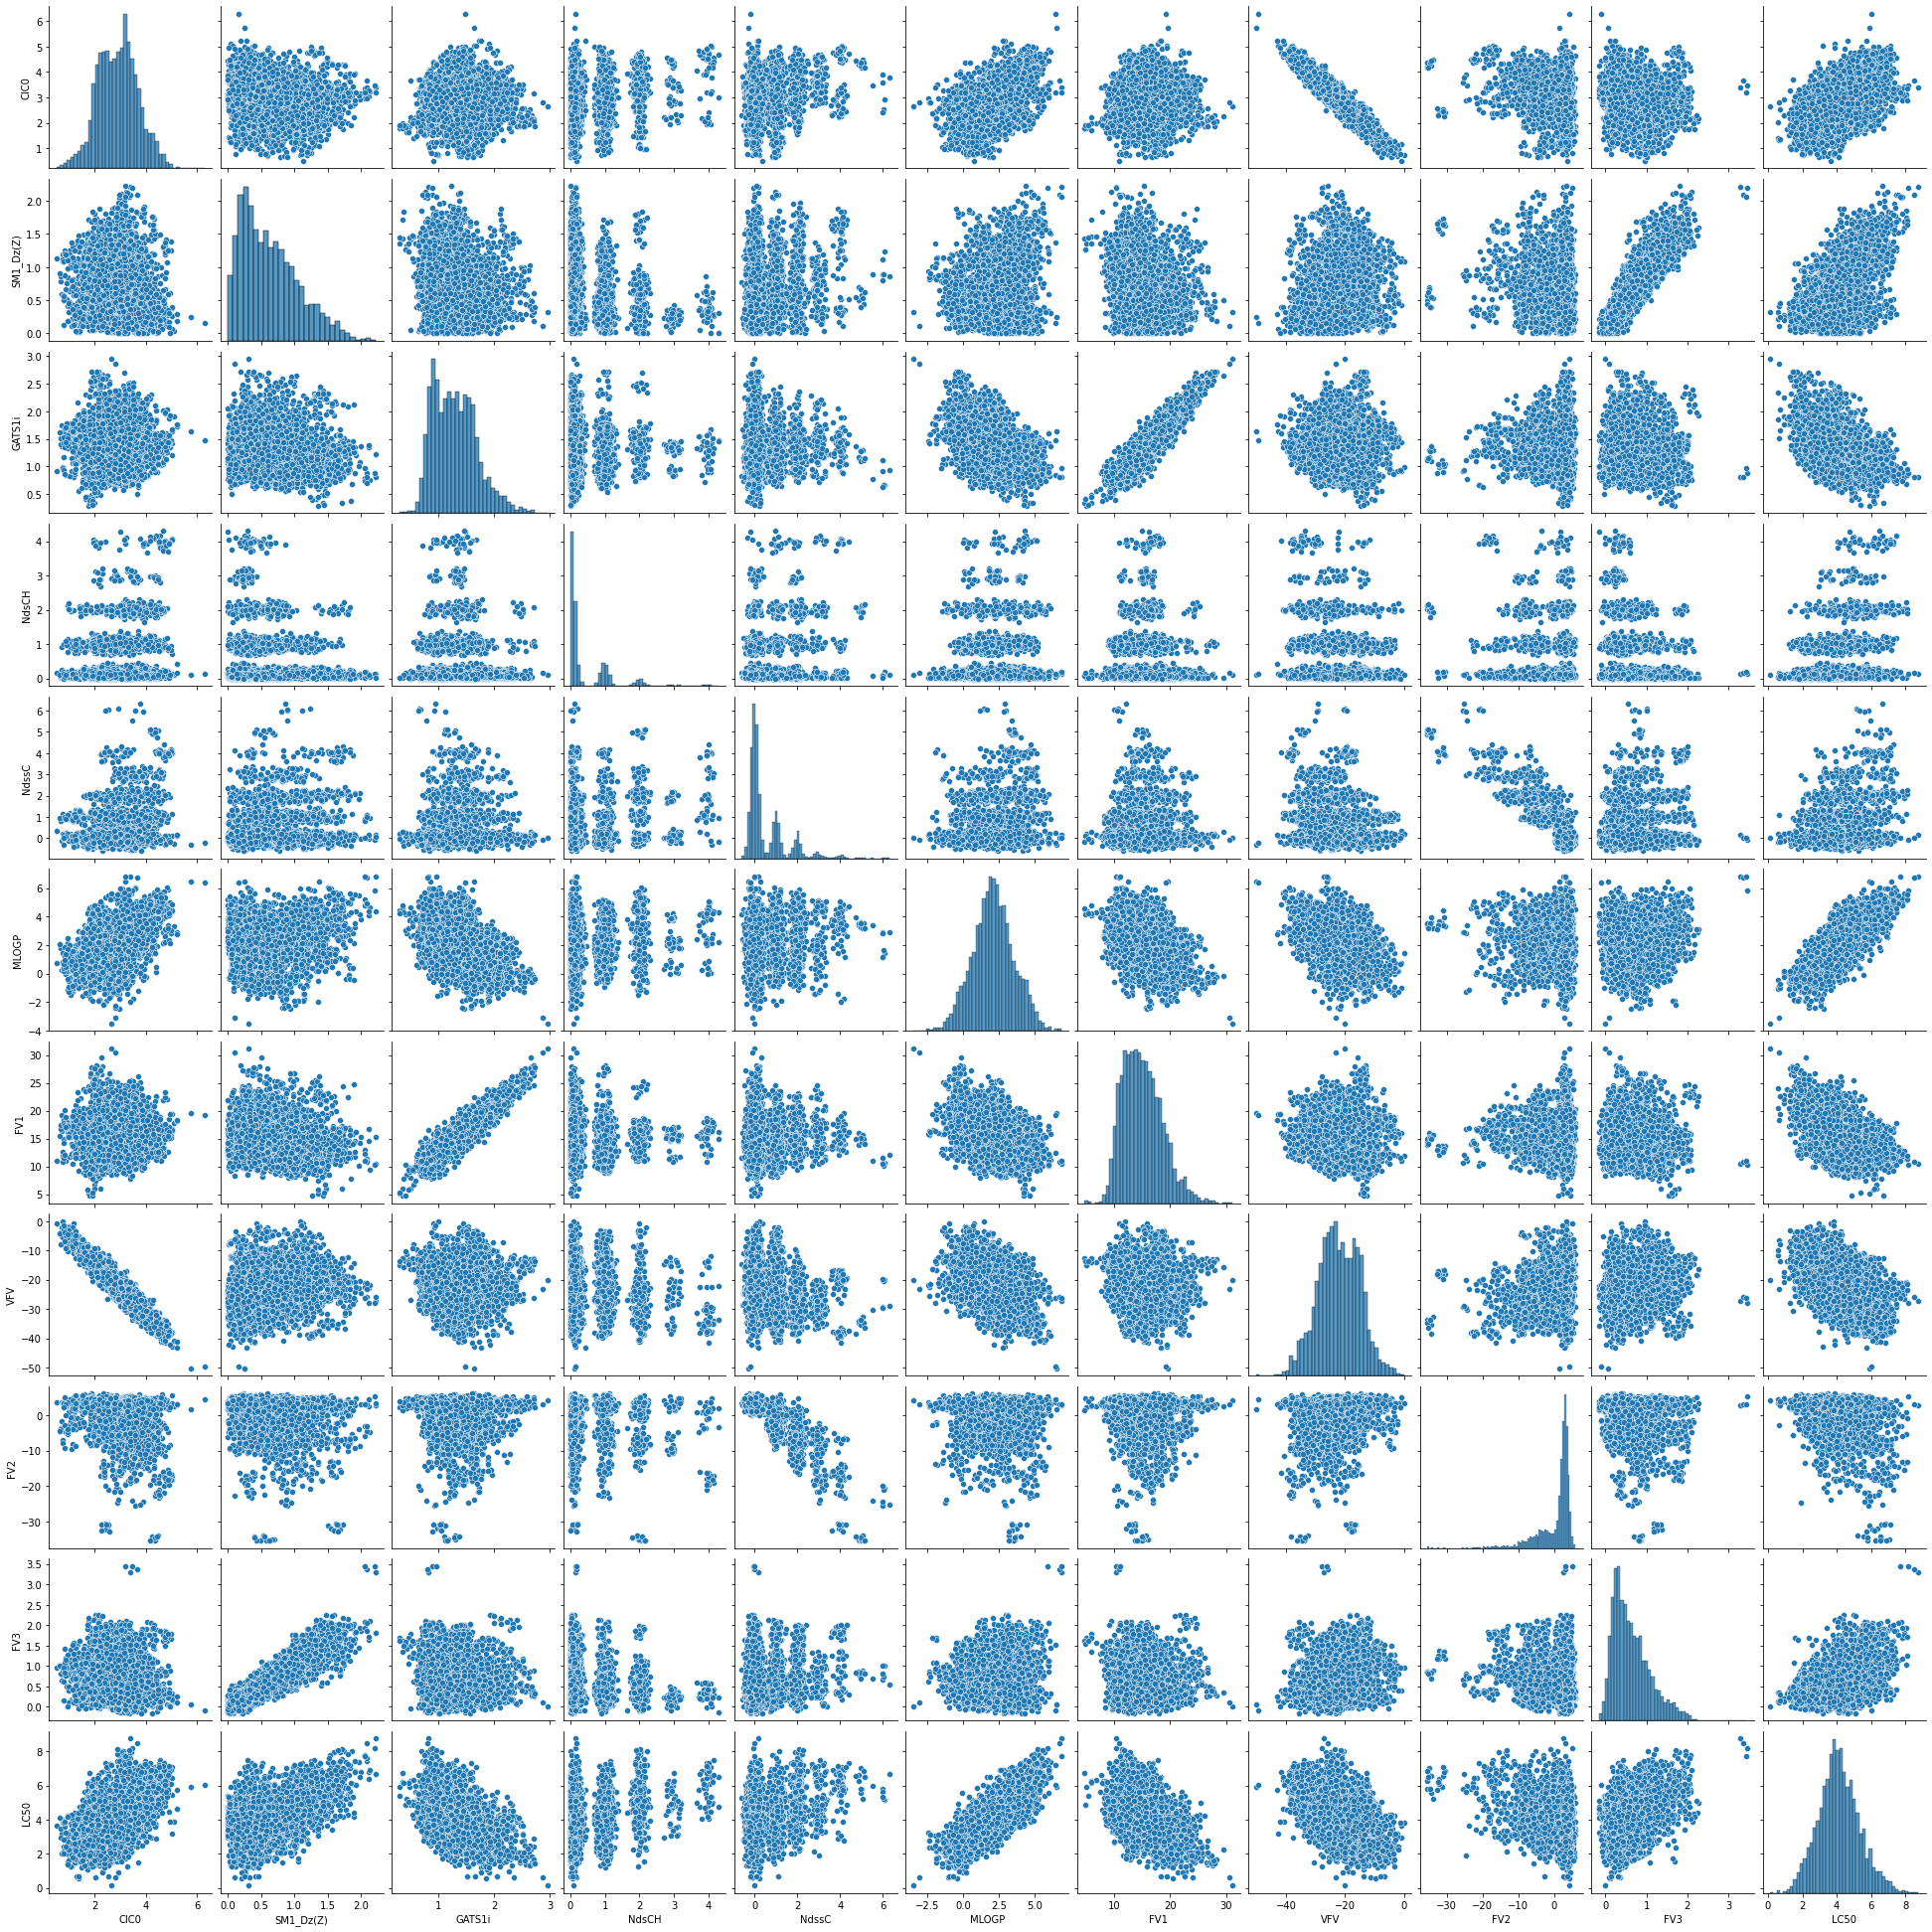

In [4]:
import seaborn as sns
features = df_chemistry_samples.columns
sns.pairplot(df_chemistry_samples[features], kind='scatter')
plt.show()

**Figure 1:** A scatter plot of the 10 descriptors and the target variable, demonstrating the distribution of each on the diagonal plots and their correlations on the off-diagonal plots.

The above scatter plot in *Figure 1* demonstrates that most descriptors have weak or no correlation between themselves, thus there is no significant degeneracy in the data, while a few descriptors like VFV and CIC0 seem to be strongly correlated. However, as seen from the right-most column of the scatter plot, VFV does not correlate strongly with the outcome (toxicity factor), so there is no need for feature selection, i.e., to remove any descriptor.

<a name="task-1"></a>
# Task 1: Regression [^](#outline)



<a name="q11"></a>

## 1.1 Linear Regression [^](#outline)



<a name="q111"></a>

#### Task 1.1.1 [^](#outline)

Our first task is to obtain a linear regression model to predict the toxicity factor LC50, using all $p$ (10) features as predictors. We can summarise our data in matrix-vector form, so that we can compactly write it as $\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta}$, where:
$$\boldsymbol{X}=\begin{bmatrix}1 & x_1^{(1)} & \dots & x_p^{(1)} \\ 1 & x_1^{(2)} & \dots & x_p^{(2)} \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_1^{(N)} & \dots & x_p^{(N)}\end{bmatrix}_{N \times (p+1)} \quad \boldsymbol{y}=\begin{bmatrix}y^{(1)} \\ \vdots \\ y^{(N)}\end{bmatrix}_{N \times 1} \quad \boldsymbol{\beta}=\begin{bmatrix} \beta_0 \\ \vdots \\ \beta_p \end{bmatrix}_{(p+1) \times 1}$$

In [5]:
X = df_chemistry_samples.iloc[:, 0:10]  # load descriptors into matrix of descriptors
X_aug = np.hstack([np.ones((X.shape[0],1)), X])  # augment matrix of descriptors to include constant terms, i.e., with b_0
y = df_chemistry_samples.iloc[:, 10]  # load ground truth target variable vector

We then define our loss function as the mean square error (MSE): $L=\frac{1}{N}\boldsymbol{e}^T\boldsymbol{e}$, where $\boldsymbol{e}=\boldsymbol{y}-\boldsymbol{\hat{y}}$, and $\boldsymbol{\hat{y}}$ is the predicted values given some vector $\boldsymbol{{\beta}}$ of parameters. Our estimate of parameters is obtained by minimising the MSE, $\underset{\boldsymbol\beta}{\text{min}} \| L \|= \underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol{y}-\boldsymbol{\hat{y}} \|^2 = \underset{\boldsymbol\beta}{\text{min}} \| \boldsymbol{y} - \boldsymbol{X} \boldsymbol\beta \|^2 $, which from a statistical perspective is equivalent to maximising the likelihood, and is given by: $$\boldsymbol\beta^{*} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y .$$

In [6]:
def maximum_likelihood_estimate(X, y):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # returns: beta_ml -> maximum likelihood estimate parameters, dimensions:  p x 1
    
    X_aug = np.hstack([np.ones((X.shape[0],1)), X])  # augment matrix X to include constant terms
    beta_ml = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y)  # explicit minimisation to obtain vector of parameters
    return beta_ml

We then compute the maximum likelihood estimate for our chemistry sample data and obtain our best estimate parameters shown below.

In [7]:
# Get the maximum likelihood estimate parameters
beta_ml = maximum_likelihood_estimate(X, y)
beta_ml_df = pd.DataFrame(beta_ml, columns=['Linear Regression'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_ml))]])
beta_ml_df

Linear Regression
$\beta_{0}$            2.616380
$\beta_{1}$            0.044714
$\beta_{2}$            1.258719
$\beta_{3}$           -0.038009
$\beta_{4}$            0.363073
$\beta_{5}$            0.004665
$\beta_{6}$            0.390510
$\beta_{7}$           -0.074603
$\beta_{8}$           -0.035707
$\beta_{9}$           -0.015259
$\beta_{10}$          -0.001803

We observe from our obtained parameters that the intercept (constant term $\beta_0$) is the largest parameter and thus contributes the most toward our target variable, thus, it was important to augment our data matrix $\boldsymbol{X}$ to include a column of $1$'s for the constant term. The relative size of the parameters indicate their predictive strength for the target variable.

Having obtained an estimate of the parameters $\boldsymbol{\beta^*}$ we can make a prediction $\boldsymbol{\hat{y}=\boldsymbol{X}\boldsymbol{\beta^*}}$ given any data $\boldsymbol{X}$, and assess/score this prediction by computing its $R^2$ score with the ground truth, i.e., the real target values for that data, $\boldsymbol{y}$.

In [8]:
def predict_using_estimate(X, beta):
    # X: matrix containing the descriptor variables
    # beta: vector of parameters
    # returns: prediction of f(X)
    
    return X @ beta

In [9]:
def r2_score(y_true, y_predicted):
    # y_true: ground truth target values
    # y_predicted: predicted / estimated target values
    # returns: R2 score, i.e., coefficient of determination regression score function

    sum_of_squares_of_residuals = np.array((y_true - y_predicted)**2).sum()  # obtain the residual sum of squares
    total_sum_of_squares = np.array((y_true - np.mean(y_true))**2).sum()  # obtain the total sum of squares
    return 1 - sum_of_squares_of_residuals/total_sum_of_squares

In [10]:
y_predicted = predict_using_estimate(X_aug, beta_ml)  # Obtain predicted target values
r2_score_sample = r2_score(y, y_predicted)  # Compute R2 score for ground truth and predicted target variable
print('Training sample data R2-score: ', r2_score_sample)

Training sample data R2-score:  0.8718259975718016


<a name="q112"></a>

#### Task 1.1.2 [^](#outline)

Similarly, we can use our obtained estimate of the parameters $\boldsymbol{\beta^*}$ to predict unseen data, i.e., our test data found in `./Data/chemistry_test.csv` and score it as before.

In [11]:
# Loading the test data set using the pandas read_csv method into a pandas DataFrame.
df_chemistry_test = pd.read_csv('./Data/chemistry_test.csv')

X_test = df_chemistry_test.iloc[:, 0:10]  # load descriptors into matrix of descriptors
X_aug_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])  # augment matrix of descriptors to include constant terms

y_test = df_chemistry_test.iloc[:, 10]  # load ground truth target variable vector
predicted_y_test = predict_using_estimate(X_aug_test, beta_ml)  # Obtain predicted target values

r2_score_test = r2_score(y_test, predicted_y_test)  # Compute R2 score for ground truth and predicted target variable
print('Test sample data R2-score: ', r2_score_test)

Test sample data R2-score:  0.8642933369927286


It can be seen that our training (in-sample) $R^2$ score is larger than that obtained from the test (out-of-sample) data, which is expected, as our linear-regression model was fitted to the training (in-sample) data. The difference between the two $R^2$ scores is relatively small, indicating that the linear regression model is not overfitting substantially, which makes it rather generalisable.

<a name="q12"></a>
## 1.2 Ridge Regression [^](#outline)

<a name="q121"></a>

#### Task 1.2.1 [^](#outline)

One of the main flaws of linear regression that we may want to address is variance; although linear regression is unbiased, it can have large variance if the data has a lot of variance itself, or if the matrix $\boldsymbol{X}$ describing the data is close to losing its full rank. One way of reducing variance is by 'shrinkage methods', i.e., aiming to induce sparsity in our model by reducing the number of descriptors used. We do this in *Ridge Regression* by adapting our loss function to include a penalty term $\lambda$ that penalises large parameters, thus, enforcing a form of 'continuous sparsity.' The modified loss function is defined as: $L_{RIDGE}(\boldsymbol{\beta})=\|\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\|^2+\lambda\|\boldsymbol{\beta}\|^2$, where $\lambda>0$ is the penalty term. The solution is 
$$\boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I)^{-1}\boldsymbol X^T\boldsymbol y \,$$

In [12]:
def ridge_estimate(X, y, penalty):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # returns: beta_ridge -> maximum likelihood estimate parameters, dimensions:  p x 1
    
    N, D = X.shape  # dimensions of matrix X
    X_aug = np.hstack([np.ones((N,1)), X])  # augment matrix X to include constant terms
    N_aug, D_aug = X_aug.shape  # dimensions of augmented matrix X_aug
    I = np.identity(D_aug)  # identity matrix of dimensions D_aug x D_aug
    # To improve the shrinkage properties of Ridge Regression so that it is not dominated by large values of the intercept of the linear model
    I[0,0] = 0
    # Explicit minimisation to obtain vector of parameters
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + penalty * I, X_aug.T @ y)
    return beta_ridge

Our next step is to identify what is the optimal hyper-parameter $\lambda$, i.e., our penalty term. We achieve this by doing *T-fold cross validation*, aiming to find a balanace between accuracy and generalisability. We thus split our data into a training set and a validation set and we repeat this process $T$ times, changing the data (folds) in the training and validation sets each time, in order to avoid overfitting to any part of the training data. We then learn our ridge rigression model $\hat{f}$ using the training data and compute the mean square error (MSE) on the validation set, where
$$\text{MSE}_t=\sum_i [\hat{f}(\boldsymbol{x}^{(i)})-y^{(i)}]^2, \quad \text{for} \: i \in \mathcal{S}_{validation}.$$

We repeat this process over all $T$ folds to obtain an average MSE, over all the splits of our data, $T$,
$$\langle \text{MSE} \rangle = \frac{1}{T}\sum_{t=1}^T \text{MSE}_t,$$

giving a measure of the generalisability of our model, i.e., how well it predicts unseen data. We tune our ridge regression penalty term using 5 equal sized folds, using 4 of the them for training and 1 for validation.

In [13]:
X_copy = X.copy()  # Copying the variable to use for folds, in order to not affect the original variable
y_copy = y.copy()  # Copying the variable to use for folds, in order to not affect the original variable

X_folds = np.array(X_copy[:-1]) # removing the last element in order to have 5 equal-sized folds (making it divisible by 5)
y_folds = np.array(y_copy[:-1]) # removing the last element in order to have 5 equal-sized folds (making it divisible by 5)

np.random.seed(10)  # fixing the random seed to make the results reproducible
p = np.random.permutation(len(y_folds))  # shuffling the data for even greater generalisability
X_folds = X_folds[p]
y_folds = y_folds[p]

# We obtain a list of the 5 index arrays, i.e., the 5 folds
folds_indexes = np.split(np.arange(len(y_folds)), 5)

In [14]:
def mean_square_error(y_true, y_predicted):
    # y_true: ground truth (correct) target values
    # y_predicted: estimated targets as returned by a regression model, e.g., linear, ridge, LASSO
    
    return np.array((y_true - y_predicted)**2).sum()

In [15]:
def ridge_cross_validation_score(X, y, folds, penalty):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # penalty: penalty term of ridge regression loss function
    
    scores = []  # an array to hold the scores (mean square error) from each fold experiment
    for i in range(len(folds)):
        validation_fold_indexes = folds[i]
        training_fold_indexes = list(set(range(y.shape[0])) - set(validation_fold_indexes))
        
        # X and y data used for training
        X_training = X[training_fold_indexes, :]
        y_training = y[training_fold_indexes]

        # X and y data used for validation
        X_validation = X[validation_fold_indexes, :]
        y_validation = y[validation_fold_indexes]
        
        beta_ridge = ridge_estimate(X_training, y_training, penalty)  # using the non-augmented (no constant terms) matrix for the ridge estimate
        X_training_aug = np.hstack([np.ones((X_training.shape[0], 1)), X_training])
        X_validation_aug = np.hstack([np.ones((X_validation.shape[0], 1)), X_validation])
        y_predicted = predict_using_estimate(X_validation_aug, beta_ridge)  # using the augmented matrix to make a prediction with the beta_ridge
        scores.append(mean_square_error(y_validation, y_predicted))

    # Return the average (over 5 folds) score (mean square error)
    return sum(scores) / len(scores)

In [16]:
def ridge_choose_best_penalty(X, y, folds, penalty_range):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # penalty_range: an array of a range of penalty terms
    
    penalty_scores = np.zeros((len(penalty_range),))  # will hold the mean square error associated with each penalty term
    
    for i, p in enumerate(penalty_range):
        penalty_scores[i] = ridge_cross_validation_score(X, y, folds, p)

    best_penalty_index = np.argmin(penalty_scores)  # the best penalty term is the one that minimises the mean square error
    return penalty_scores, penalty_range[best_penalty_index]

Now we can 'scan' a range of penalty terms in the range $[0, 2]$ and plot the average MSE, $\langle \text{MSE} \rangle$. The *best penalty term* is the one that results in the minimum $\langle \text{MSE} \rangle$, which can be seen below in *Figure 2*.

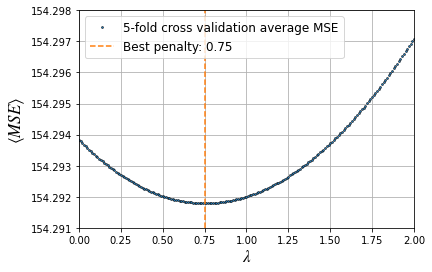

In [17]:
x_space = np.linspace(0, 2, 201)
penalty_scores_ridge, best_penalty_ridge = ridge_choose_best_penalty(X_folds, y_folds, folds_indexes, x_space)

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(x_space, penalty_scores_ridge, 'o', markeredgecolor='k', markersize=2, markeredgewidth=0.5, label='5-fold cross validation average MSE')
plt.plot(np.linspace(best_penalty_ridge, best_penalty_ridge, 100), np.linspace(154.291, 154.298, 100), '--', label='Best penalty: {}'.format(round(best_penalty_ridge, 3)))
plt.xlabel(r'$\lambda$', fontname='Times New Roman', fontsize=17)
plt.ylabel(r'$\langle MSE \rangle$', fontname='Times New Roman', fontsize=17)
plt.legend()
plt.grid()
plt.xlim(0, 2)
plt.ylim(154.291, 154.298)
plt.show()

**Figure 2:** The average MSE $\langle \text{MSE} \rangle$ plotted against a range of penalty terms for ridge regression, using 5-fold cross-validation, shown in blue dots. The vertical orange dotted line represents the best penalty term (minimum $\langle \text{MSE} \rangle$), given when $\lambda=0.75$.

Figure 2 demonstrates that increasing the penalty hyper-parameter decreases the $\langle \text{MSE} \rangle$ for the validation set, as expected, because at the beginning the $\langle \text{MSE} \rangle$ is mostly dominated by the variance (for small values of $\lambda$ given that it relates linearly with variance and with the square of the bias), which decreases as $\lambda$ increases. However, as $\lambda$ keeps increasing, and the variance decreases further, the bias begins to increase and dominates the $\langle \text{MSE} \rangle$, which begins to increase.

Moreover, as our penalty hyper-parameter keeps increasing, the complexity of the model is reduced, hence, becoming a worse fit for the data, and thus increasing the $\langle \text{MSE} \rangle$.

Having performed our 5-fold cross validation we have obtained the optimised hyper-paramter penaty term $\lambda=0.75$. This penalty term is the one that minimises the average MSE $\langle \text{MSE} \rangle = \mathbb{E}[(\hat{f}-y)^2]=\text{var}(\hat{f}) + (y-\mathbb{E}[\hat{f}])^2=\text{variance} + \text{bias}^2$, and is the one that results in the perfect trade-off between these two properties; it finds the best balance of increased bias and decreased variance that is the most generalisable on unseen data.

<a name="q122"></a>

#### Task 1.2.2 [^](#outline)

We now fix this optimised penalty term and use it to retrain the model on the entire train data and obtain an (in-sample) $R^2$ score. We also use this penalty term to obtain an $R^2$ score on the test data (out-of-sample), summarised in the table below.

In [18]:
beta_ridge = ridge_estimate(X, y, best_penalty_ridge)  # obtaining the beta_ridge using the best penalty from the 5-fold cross-validation
beta_ridge_df = pd.DataFrame(beta_ridge, columns=['Ridge Regression - Train'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_ridge))]])
shrinkage_factor_df_train = pd.DataFrame(((beta_ridge.reshape(-1,)-beta_ml)/beta_ml*100), columns=['Ridge Regression - Train % Diff'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_ridge))]])
predicted_y = predict_using_estimate(X_aug, beta_ridge)  # making a new prediction on the sample data with the new beta_ridge
r2_score_sample_ridge = r2_score(y, predicted_y)  # Compute R2 score for ground truth and predicted target variable

beta_ridge_test = ridge_estimate(X_test, y_test, best_penalty_ridge)   # obtaining the beta_ridge using the best penalty from the 5-fold cross-validation
beta_ridge_test_df = pd.DataFrame(beta_ridge_test, columns=['Ridge Regression - Test'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_ridge_test))]])
shrinkage_factor_df_test = pd.DataFrame(((beta_ridge_test.reshape(-1,)-beta_ml)/beta_ml*100), columns=['Ridge Regression - Test % Diff'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_ridge_test))]])
predicted_y_test = predict_using_estimate(X_aug_test, beta_ridge_test)  # making a new prediction on the test data with the new beta_ridge
r2_score_test_ridge = r2_score(y_test, predicted_y_test)  # Compute R2 score for ground truth and predicted target variable
display(pd.concat([beta_ml_df, beta_ridge_df, beta_ridge_test_df, shrinkage_factor_df_train, shrinkage_factor_df_test], axis=1))
print('Ridge sample data R2-score: ', r2_score_sample_ridge)
print('Ridge test data R2-score: ', r2_score_test_ridge)

Linear Regression  Ridge Regression - Train  \
$\beta_{0}$            2.616380                  2.618328   
$\beta_{1}$            0.044714                  0.044311   
$\beta_{2}$            1.258719                  1.251909   
$\beta_{3}$           -0.038009                 -0.037789   
$\beta_{4}$            0.363073                  0.362779   
$\beta_{5}$            0.004665                  0.004971   
$\beta_{6}$            0.390510                  0.390664   
$\beta_{7}$           -0.074603                 -0.074639   
$\beta_{8}$           -0.035707                 -0.035710   
$\beta_{9}$           -0.015259                 -0.015247   
$\beta_{10}$          -0.001803                  0.003507   

              Ridge Regression - Test  Ridge Regression - Train % Diff  \
$\beta_{0}$                  2.556182                         0.074431   
$\beta_{1}$                  0.028213                        -0.901753   
$\beta_{2}$                  1.274083                        -0.540984   
$\beta_{3}$                 -0.141471                        -0.580485   
$\beta_{4}$                  0.352748                        -0.081128   
$\beta_{5}$                  0.028322                         6.561213   
$\beta_{6}$                  0.390036                         0.039336   
$\beta_{7}$                 -0.060866                         0.048190   
$\beta_{8}$                 -0.036126                         0.008070   
$\beta_{9}$                 -0.011191                        -0.076825   
$\beta_{10}$                 0.000939                      -294.501376   

              Ridge Regression - Test % Diff  
$\beta_{0}$                        -2.300815  
$\beta_{1}$                       -36.902104  
$\beta_{2}$                         1.220590  
$\beta_{3}$                       272.199934  
$\beta_{4}$                        -2.843969  
$\beta_{5}$                       507.067847  
$\beta_{6}$                        -0.121330  
$\beta_{7}$                       -18.412837  
$\beta_{8}$                         1.173653  
$\beta_{9}$                       -26.657208  
$\beta_{10}$                     -152.086380

Ridge sample data R2-score:  0.8718249224861692
Ridge test data R2-score:  0.8648405039998466


The table above summarises the parameters obtained from linear regression as well as ridge regression (from the training and the test data), demonstrating that the penalty term has enforced some level of continuous sparsity, as some parameter values of ridge are slightly smaller. The best penalty obtained resulted in $R^2$ scores of $0.8718249224861692$ and $0.8648405039998466$ for train and test data respectively, which are $0.000123$% smaller and $0.0367$% higher than the linear regression $R^2$ scores respectively. This shows that the in-sample ridge-regression $R^2$ score is slightly lower, while the out-of-sample $R^2$ score is slightly higher, showing that ridge regression is slightly more generalisable the linear regression. This could be explained to some degree from the fact that the penalty hyper-parameter in ridge regression 'tunes-out' to some extent parameters that co-relate and thus provide degenerate / duplicate information. Furthermore, the slightly higher out-of-sample $R^2$ of ridge regression could be explained by the fact that the penalty hyper-parameter reduces the complexity of the model, and thus, we are 'overfitting' less, making our ridge model a bit more generalisable to unseen data. This only holds, of course, up to a point (beyond which we begin to underfit), however, the $R^2$ scores above were obtained using the optimal penalty hype-parameter value, which finds the perfect balance between over- and under-fitting.

<a name="q13"></a>

## 1.3 Relaxation of Lasso Regression [^](#outline)




<a name="q131"></a>

#### Task 1.3.1 [^](#outline)

In this section we consider a different type of shrinkage method, the LASSO regression, which penalises large parameters in a slightly different way. Specifically, we consider a *smooth* version of LASSO where the regularisation (penalty) term is approximated via specific smooth functions, in this case the Huber functions, $L_c$, which are differentiable, demonstrated below:

$$L_{LASSO}(\boldsymbol{\beta})=\|\boldsymbol{y} - \boldsymbol{X}\boldsymbol{\beta} \|^2 + \lambda \sum_i^p L_c(\beta_i),$$

$$\text{where} \quad L_c(\beta)= \begin{cases} \frac{1}{2}\beta^2 \quad\quad\quad\quad \text{for} \: |\beta| \le c, \\ c(|\beta|-\frac{1}{2}c), \quad \: \text{otherwise}.\end{cases}$$

where $p$ is the number of descriptors (predictors), $c$ is a constant that determines the *sharpness* of the Huber functions, and $\lambda$ is the penalty hyper-parameter, as in the ridge regression loss function.

<br> The best estimate parameters will be found using gradient descent, requiring to differentiate our loss function $L_{LASSO}$. Taking the derivate of the loss function, $\nabla_\boldsymbol{\beta} L_{LASSO}$ we get:

$$ \nabla_\boldsymbol{\beta} L_{LASSO} = -\frac{2}{N}\boldsymbol{X}\boldsymbol{y} + \frac{2}{N}\boldsymbol{X}\boldsymbol{X}\boldsymbol{\beta} + \lambda \nabla_\boldsymbol{\beta} L_c(\beta),$$

where:

$$\nabla_\boldsymbol{\beta} L_c(\beta)=\begin{pmatrix} \beta_1 \mathbb{1}(|\beta_1| \le c ) + c\mathbb{I}(|\beta_1| > c, \beta_1 >0) -c\mathbb{I}(|\beta_1| > c, \beta_1 < 0) \\ \vdots \\ \beta_p \mathbb{1}(|\beta_p| \le c ) + c\mathbb{I}(|\beta_p| > c, \beta_p >0) -c\mathbb{I}(|\beta_p| > c, \beta_p < 0)\end{pmatrix}$$

which are 3 mutually exclusive events:
- if $|\beta_i| \le c, \: \text{then} \: \nabla_\beta L_c(\beta_i)= \beta_i$ 
- if $|\beta_i| > c, \beta_i >0, \: \text{then} \: \nabla_\beta L_c(\beta_i)= c$
- if $|\beta_i| > c, \beta_i < 0, \: \text{then} \: \nabla_\beta L_c(\beta_i)= -c$

The Huber function and its derivative function are summarised below.

In [19]:
def huber(beta, c=1e-6):
    if abs(beta) <= c:
        return 0.5*beta**2
    else:
        return c*(abs(beta) - 0.5*c)

def grad_huber(beta, c=1e-3):
    # beta: vector of parameters
    # c: constant regulating 'sharpness' of Huber functions
    
    if abs(beta) <= c:
        return beta
    else:
        return np.sign(beta)*c

# vectorizing the above gradient function allows to provide the entire vector as an input and compute the Huber function on each element quickly
vectorized_grad_huber = np.vectorize(grad_huber)

The gradient descent is implemented by iteratively moving in the direction of $-\nabla_\boldsymbol{\beta} L_{LASSO}$ by some step size $\eta$ for a given number of iterations, updating the parameters $\boldsymbol{\beta}$ each time, i.e.:

$$\boldsymbol{\beta}_{k+1} = \boldsymbol{\beta}_k - \eta\nabla_\boldsymbol{\beta} L_{LASSO}(\boldsymbol{\beta}_k).$$

In order for the intercept (contant term) to not be affected by shrinkage, we multiply the first element of $\nabla_\boldsymbol{\beta} L_c(\beta)$ by 0, thus improving shrinkage functionality.

In [20]:
def minimize_ls_huber(X, y, lambd=0, n_iters=10000, step_size=1e-3):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # beta: vector of parameters
    # n_iters: number of iterations of gradient descent
    # step_size: step size in direction of (negative) maximum gradient

    X = np.hstack([np.ones((X.shape[0],1)), X])
    
    n, p = X.shape
    # terms from gradient of linear-regression part of the loss function
    XX = X.T @ X / n
    Xy = (X.T @ y / n).reshape(-1, 1)
    
    # initialise betas
    beta = np.zeros(shape=(p, 1))
    
    # create a new array of lambdas where the first term is set to 0, so that shrinkage does not affect the intercept (constant term)
    lambd_updated = lambd*np.ones(shape=(p, 1))
    lambd_updated[0] = 0
    
    for i in range(n_iters):
        huber_grad = vectorized_grad_huber(beta)
        
        grad = -2 * Xy + 2 * XX @ beta + lambd_updated * huber_grad
        # gradient descent update
        beta = beta - step_size*grad
    
    return beta

<a name="q132"></a>

#### Task 1.3.2 [^](#outline)

As in Task 1.2.1, we perform 5-fold cross-validation with the same folds that were used before, to tune the penalty hyper-parameter $\lambda$ (the sharpness term $c$ is fixed to $c=0.001$). We 'scan' a range of penalty terms in the range $[8, 20]$ and plot the average MSE, $\langle \text{MSE} \rangle$. The *best penalty term* is the one that results in the minimum $\langle \text{MSE} \rangle$, which can be seen below in *Figure 3*.

In [21]:
def lasso_cross_validation_score(X, y, folds, penalty):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # penalty: penalty term of lasso regression loss function
    
    scores = []
    for i in range(len(folds)):
        validation_fold_indexes = folds[i]
        training_fold_indexes = list(set(range(y.shape[0])) - set(validation_fold_indexes))
        
        # X and y data used for training
        X_training = X[training_fold_indexes, :]
        y_training = y[training_fold_indexes]

        # X and y data used for validation
        X_validation = X[validation_fold_indexes, :]
        y_validation = y[validation_fold_indexes]
        
        # X_training_aug = np.hstack([np.ones((X_training.shape[0],1)), X_training])
        beta_lasso = minimize_ls_huber(X_training, y_training, lambd=penalty)  # using the non-augmented (no constant terms) matrix for the lasso estimate
        
        X_validation_aug = np.hstack([np.ones((X_validation.shape[0], 1)), X_validation])
        y_predicted = predict_using_estimate(X_validation_aug, beta_lasso)  # using the augmented matrix to make a prediction with the beta_lasso
        
        scores.append(mean_square_error(y_validation, y_predicted.flatten()))
        
    # Return the average (over 5 folds) score (mean square error)
    return sum(scores) / len(scores)

In [22]:
def lasso_choose_best_penalty(X, y, folds, penalty_range):
    # X: matrix containing the descriptor variables, dimensions: N x p
    # y: vector containing target observed variable, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: N/5 x 1
    # penalty_range: an array of a range of penalty terms
    
    penalty_scores = np.zeros((len(penalty_range),))  # will hold the mean square error associated with each penalty term
    
    for i, p in enumerate(penalty_range):
        penalty_scores[i] = lasso_cross_validation_score(X, y, folds, p)
    
    best_penalty_index = np.argmin(penalty_scores)  # the best penalty term is the one that minimises the mean square error
    return penalty_scores, penalty_range[best_penalty_index]

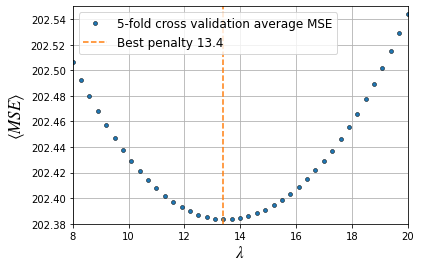

In [23]:
x_space = np.linspace(8, 20, 41)
penalty_scores_lasso, best_penalty_lasso = lasso_choose_best_penalty(X_folds, y_folds, folds_indexes, x_space)

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(x_space, penalty_scores_lasso, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='5-fold cross validation average MSE')
plt.plot(np.linspace(best_penalty_lasso, best_penalty_lasso, 100), np.linspace(202.38, 202.56, 100), '--', label='Best penalty {}'.format(round(best_penalty_lasso, 2)))
plt.xlabel(r'$\lambda$', fontname='Times New Roman', fontsize=17)
plt.ylabel(r'$\langle MSE \rangle$', fontname='Times New Roman', fontsize=17)
plt.legend()
plt.grid()
plt.xlim(8, 20)
plt.ylim(202.38, 202.55)
plt.show()

**Figure 3:** The average MSE $\langle \text{MSE} \rangle$ plotted against a range of penalty terms for LASSO regression, using 5-fold cross-validation, shown in blue dots. The vertical orange dotted line represents the best penalty term (minimum $\langle \text{MSE} \rangle$), which is $\lambda=13.4$.

We now fix this optimised penalty term and use it to retrain the model on the entire train data and obtain an (in-sample) $R^2$ score. We also use this penalty term to obtain an $R^2$ score on the test data (out-of-sample), summarised in the table below.

In [24]:
beta_lasso = minimize_ls_huber(X, y, best_penalty_lasso)  # obtaining the beta_lasso using the best penalty from the 5-fold cross-validation
beta_lasso_df = pd.DataFrame(beta_lasso, columns=['LASSO Regression - Train'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_lasso))]])
shrinkage_factor_df_train = pd.DataFrame(((beta_lasso.reshape(-1,)-beta_ml)/beta_ml*100), columns=['LASSO Regression - Train % Diff'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_lasso))]])
predicted_y_lasso = predict_using_estimate(X_aug, beta_lasso)  # making a new prediction on the sample data with the new beta_lasso
y = np.array(y).reshape(-1, 1)
r2_score_sample_lasso = r2_score(y, predicted_y_lasso)  # Compute R2 score for ground truth and predicted target variable

beta_lasso_test = minimize_ls_huber(X_test, y_test, best_penalty_lasso)  # obtaining the beta_lasso using the best penalty from the 5-fold cross-validation
beta_lasso_test_df = pd.DataFrame(beta_lasso_test, columns=['LASSO Regression - Test'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_lasso_test))]])
shrinkage_factor_df_test = pd.DataFrame(((beta_lasso_test.reshape(-1,)-beta_ml)/beta_ml*100), columns=['LASSO Regression - Test % Diff'], index=[[r'$\beta_{%s}$' %i for i in range(len(beta_lasso_test))]])
predicted_y_lasso_test = predict_using_estimate(X_aug_test, beta_lasso_test)  # making a new prediction on the test data with the new beta_lasso
y_test = np.array(y_test).reshape(-1, 1)
r2_score_test_lasso = r2_score(y_test, predicted_y_lasso_test)  # Compute R2 score for ground truth and predicted target variable

display(pd.concat([beta_ml_df, beta_lasso_df, beta_lasso_test_df, shrinkage_factor_df_train, shrinkage_factor_df_test], axis=1))
print('Lasso sample data R2-score: ', r2_score_sample_lasso)
print('Lasso test data R2-score: ', r2_score_test_lasso)

Linear Regression  LASSO Regression - Train  \
$\beta_{0}$            2.616380                  1.154132   
$\beta_{1}$            0.044714                  0.287068   
$\beta_{2}$            1.258719                  0.948517   
$\beta_{3}$           -0.038009                 -0.092996   
$\beta_{4}$            0.363073                  0.381260   
$\beta_{5}$            0.004665                  0.040408   
$\beta_{6}$            0.390510                  0.441866   
$\beta_{7}$           -0.074603                 -0.016196   
$\beta_{8}$           -0.035707                 -0.020894   
$\beta_{9}$           -0.015259                  0.000866   
$\beta_{10}$          -0.001803                  0.465044   

              LASSO Regression - Test  LASSO Regression - Train % Diff  \
$\beta_{0}$                  1.132112                       -55.888207   
$\beta_{1}$                  0.283400                       542.012093   
$\beta_{2}$                  0.925560                       -24.644238   
$\beta_{3}$                 -0.114373                       144.667812   
$\beta_{4}$                  0.377519                         5.009035   
$\beta_{5}$                  0.158517                       766.129938   
$\beta_{6}$                  0.430775                        13.150883   
$\beta_{7}$                 -0.014258                       -78.289901   
$\beta_{8}$                 -0.020572                       -41.483406   
$\beta_{9}$                  0.022477                      -105.675150   
$\beta_{10}$                 0.494515                    -25890.502885   

              LASSO Regression - Test % Diff  
$\beta_{0}$                       -56.729821  
$\beta_{1}$                       533.807552  
$\beta_{2}$                       -26.468062  
$\beta_{3}$                       200.907290  
$\beta_{4}$                         3.978610  
$\beta_{5}$                      3297.756406  
$\beta_{6}$                        10.310953  
$\beta_{7}$                       -80.888114  
$\beta_{8}$                       -42.386803  
$\beta_{9}$                      -247.307292  
$\beta_{10}$                   -27524.900487

Lasso sample data R2-score:  0.8315302041551212
Lasso test data R2-score:  0.8242353246939493


The table above summarises the parameters obtained from LASSO regression and compares them to those obtained with linear regression (from the training and the tet data), demonstrating that the penalty term has enforced some level of continuous sparsity, as some parameter values of ridge are slightly smaller. The best penalty obtained resulted in $R^2$ scores of $0.8315302041551212$ and $0.8242353246939493$ for train and test data respectively, which are $4.622$% smaller and $4.635$% smaller than the linear regression $R^2$ scores respectively. This shows that both the in-sample and out-of-sample LASSO regression $R^2$ scores are a bit lower, demonstrating an increased bias in relation to linear regression.

<a name="q133"></a>

#### Task 1.3.3 [^](#outline)

The regression coefficients, $R^2$ scores, are summarised below:

In [25]:
R_linear = np.array([0.8718259975718016, 0.8642933369927286])
R_ridge = np.array([0.8718249224861692, 0.8648405039998466])
R_lasso = np.array([0.8315302041551212, 0.8242353246939493])
R_linear_df = pd.DataFrame(R_linear, columns=['Linear Regression'], index=[['Train', 'Test']])
R_ridge_df = pd.DataFrame(R_ridge, columns=['Ridge Regression'], index=[['Train', 'Test']])
R_lasso_df = pd.DataFrame(R_lasso, columns=['LASSO Regression'], index=[['Train', 'Test']])
percentage_ridge_df = pd.DataFrame((R_ridge-R_linear)/R_linear*100, columns=['Ridge Percentage %'], index=[['Train', 'Test']])
percentage_lasso_df = pd.DataFrame((R_lasso-R_linear)/R_linear*100, columns=['Ridge Percentage %'], index=[['Train', 'Test']])
display(pd.concat([R_linear_df, R_ridge_df, R_lasso_df, percentage_ridge_df, percentage_lasso_df], axis=1))

Linear Regression  Ridge Regression  LASSO Regression  \
Train           0.871826          0.871825          0.831530   
Test            0.864293          0.864841          0.824235   

       Ridge Percentage %  Ridge Percentage %  
Train           -0.000123            -4.62200  
Test             0.063308            -4.63477

The table above demonstrates that ridge regression has much closer $R^2$ scores to linear regression than LASSO regression has, demonstrating that LASSO regression trades off more bias for variance than ridge regression. That is, LASSO regression achieves greater shrinkage than ridge regression, and thus reduces variance more, but at an increased cost of greater bias. This effect can also be summarised by plotting the parameters from each model on a bar plot, shown below in *Figure 4*, which demonstrates that on the whole, LASSO achieves greater shrinkage as the magnitude of the vector of parameters $\boldsymbol{\beta}$ is more shrank than that of ridge regression (both in comparison to linear regression). One can argue whether the increased computational complexity for LASSO is necessiated, given the increased bias in comparison to ridge, at least for this particular regression problem.

<AxesSubplot:>

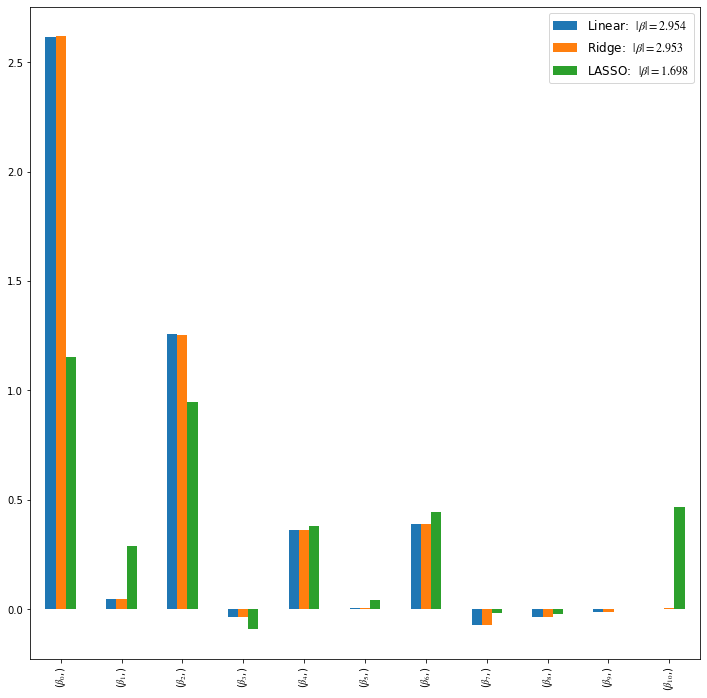

In [26]:
concatenated_betas = pd.concat([beta_ml_df, beta_ridge_df, beta_lasso_df], axis=1)
concatenated_betas.columns = ['Linear:  ' r'$|\beta|={}$'.format(round(np.linalg.norm(beta_ml), 3)), \
                              'Ridge:  ' r'$|\beta|={}$'.format(round(np.linalg.norm(beta_ridge), 3)), \
                              'LASSO:  ' r'$|\beta|={}$'.format(round(np.linalg.norm(beta_lasso), 3))]
concatenated_betas.plot.bar(figsize=(12, 12))

**Figure 4:** A bar plot demonstrating the relative size of all parameters $\boldsymbol{\beta}$ from all 3 regression models: linear, ridge, and LASSO. In general, ridge regression achieved a small amount of shrinkage and LASSO achieved a bigger amount of shrinkage, demonstrated on the bar plot by the magnitude of the vector of parameters $\boldsymbol{\beta}$, which is $2.954$, $2.953$, and $1.698$ for linear, ridge, and LASSO regression respectively.

<a name="task-2"></a>

# Task 2: Classification [^](#outline)

<a name="q21"></a>

## 2.1 k-NN Classifier [^](#outline)

As with the regression tasks in ***Task 1*** we begin by importing the dataset found in `./Data/tumour_samples.csv` using the pandas package, and inspect it, printing the first 5 rows.

In [27]:
# Loading the sample data set using the pandas read_csv method into a pandas DataFrame.
df_tumour_samples = pd.read_csv('./Data/tumour_samples.csv')
# Outputing the first 5 samples (rows) to inspect the data.
df_tumour_samples.head()

Unnamed: 0  n1_radius  n1_texture  n1_perimeter     n1_area  n1_smoothness  \
0           0  10.855170   15.248290     69.167041  359.534878       0.105488   
1           1  10.068958   15.532758     66.130635  330.040665       0.099813   
2           2  12.271409   18.100314     78.195610  421.537832       0.105147   
3           3  10.531733   18.452486     67.227069  340.063033       0.086041   
4           4  12.367686   14.399191     80.643814  460.849710       0.106410   

   n1_compactness  n1_concavity  n1_concave_points  n1_symmetry  ...  \
0        0.080200      0.066410           0.034194     0.182796  ...   
1        0.109540      0.057583           0.023322     0.195650  ...   
2        0.095315      0.043317           0.031539     0.188801  ...   
3        0.049961      0.049709           0.011046     0.203093  ...   
4        0.101420      0.020806           0.021990     0.195326  ...   

   n3_texture  n3_perimeter     n3_area  n3_smoothness  n3_compactness  \
0   18.984557     81.443134  466.879302       0.149080        0.200185   
1   22.840293     82.133171  473.367822       0.125478        0.330466   
2   26.365608     84.598334  620.586067       0.146766        0.118707   
3   24.385385     73.296855  429.675600       0.100060        0.143683   
4   19.614305     89.910502  472.323112       0.138135        0.276127   

   n3_concavity  n3_concave_points  n3_symmetry  n3_fractal_dimension  \
0      0.205695           0.111592     0.335999              0.093477   
1      0.283304           0.088021     0.312882              0.096158   
2      0.147900           0.050402     0.291805              0.069556   
3      0.177225           0.028111     0.287749              0.073174   
4      0.151098           0.074396     0.345258              0.095830   

   DIAGNOSIS  
0          B  
1          B  
2          B  
3          B  
4          B  

[5 rows x 32 columns]

We observe that our data is comprised of 31 descriptors (columns 1-31, Unnamed:0 to n3_fractal_dimension) and a target variable (column 32) which is the tumour classification, 'M' for malignant and 'B' for benign. We notice that the first column 'Unnamed:0' is probably there by accident and does not represent any meaningful description of the data, so we start by removing this feature in order to not consider it in our models. We then also make sure that there are no empty / NaN entries, and that all data is of the appropriate type, in this case float.

In [28]:
# the if-statement ensures this is only done once, at the beginning (in case someone wants to refresh the Pandas DataFrame)
if 'Unnamed: 0' in df_tumour_samples.columns:
    df_tumour_samples = df_tumour_samples.drop('Unnamed: 0', 1)  # we remove the 'wrong' column from the data set
# We obtain an array of the data-type of all columns
data_type = np.array([df_tumour_samples.dtypes[i] for i in range(df_tumour_samples.shape[1]-1)])
assert(data_type.all() == float)  # we assert that all columns are of type float
assert(df_tumour_samples.isnull().values.any() == False)  # we assert that there is no empty / NaN entry in any column
df_tumour_samples.head()

n1_radius  n1_texture  n1_perimeter     n1_area  n1_smoothness  \
0  10.855170   15.248290     69.167041  359.534878       0.105488   
1  10.068958   15.532758     66.130635  330.040665       0.099813   
2  12.271409   18.100314     78.195610  421.537832       0.105147   
3  10.531733   18.452486     67.227069  340.063033       0.086041   
4  12.367686   14.399191     80.643814  460.849710       0.106410   

   n1_compactness  n1_concavity  n1_concave_points  n1_symmetry  \
0        0.080200      0.066410           0.034194     0.182796   
1        0.109540      0.057583           0.023322     0.195650   
2        0.095315      0.043317           0.031539     0.188801   
3        0.049961      0.049709           0.011046     0.203093   
4        0.101420      0.020806           0.021990     0.195326   

   n1_fractal_dimension  ...  n3_texture  n3_perimeter     n3_area  \
0              0.066968  ...   18.984557     81.443134  466.879302   
1              0.069572  ...   22.840293     82.133171  473.367822   
2              0.063341  ...   26.365608     84.598334  620.586067   
3              0.064948  ...   24.385385     73.296855  429.675600   
4              0.064605  ...   19.614305     89.910502  472.323112   

   n3_smoothness  n3_compactness  n3_concavity  n3_concave_points  \
0       0.149080        0.200185      0.205695           0.111592   
1       0.125478        0.330466      0.283304           0.088021   
2       0.146766        0.118707      0.147900           0.050402   
3       0.100060        0.143683      0.177225           0.028111   
4       0.138135        0.276127      0.151098           0.074396   

   n3_symmetry  n3_fractal_dimension  DIAGNOSIS  
0     0.335999              0.093477          B  
1     0.312882              0.096158          B  
2     0.291805              0.069556          B  
3     0.287749              0.073174          B  
4     0.345258              0.095830          B  

[5 rows x 31 columns]

The unecessary column is now removed and all assertions return True, thus, we confirm the dataset is 'clean'.
<br> Moreover, we can see that some of the descriptors are as much as 5 orders of magnitude different, so scaling the data $\boldsymbol{X}$ will significantly improve our analysis, removing biasing of descriptors with larger values. We split our data-set into our descriptors and our target variable, the tumour classification, and 'standardise' the descriptors using the function defined below. We also convert the tumour classification from symbolic, i.e., 'B' and 'M', into $0$s and $1$s respectively, for easier manipulation.

In [29]:
X_class = df_tumour_samples.iloc[:, 0:30]  # load descriptors into matrix of descriptors
y = df_tumour_samples.iloc[:, 30]  # load ground truth target variable vector
y = [0 if el == 'B' else 1 for el in y]  # convert classification from symbolic to numeric B -> 0 and M -> 1

In [30]:
def standardise(X):
    # standardises the descriptors
    mu = np.mean(X, 0)
    sigma = np.std(X, 0)
    X_std = (X - mu) / sigma
    return X_std

In [31]:
X = standardise(X_class)

Due to the large number of descriptors it is hard to visualise the data, i.e., a scatter plot would produce $31\times31=961$ subplots which would be illegible. However, we can compute the correlation matrix and plot the lower triangular matrix of correlation on a heatmap, in order to see how the descriptors corelate with each other and with the target variable (the tumour classification). *Figure 5* depicts the lower triangular correlation matrix for the data (excluding the diagonal terms) where two descriptors have a Pearson product-moment correlation coefficient over $0.7$, demonstrating strong correlation.

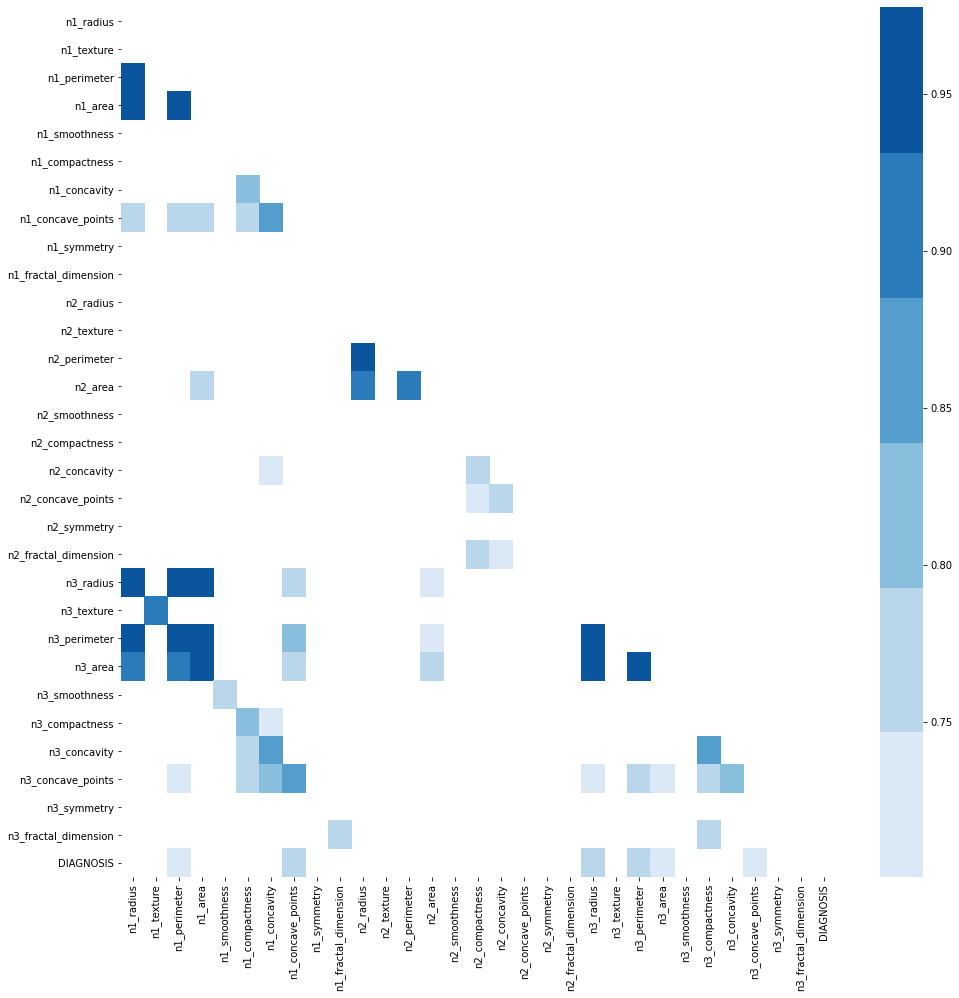

In [32]:
entire_data = pd.concat([X, pd.DataFrame(y, columns=['DIAGNOSIS'])], axis=1)  # concatenate all the data back into a Pandas DataFrame
correlation_coefficient_matrix = np.corrcoef(entire_data.to_numpy().T)  # Transpose the data to get it in the form necessary for the numpy function
for i in range(correlation_coefficient_matrix.shape[0]):
    correlation_coefficient_matrix[i][i] = 0
# organise the correlation matrix into a Pandas DataFrame again
correlation_coefficient_matrix_df = pd.DataFrame(np.tril(correlation_coefficient_matrix), columns=[entire_data.columns], index=[entire_data.columns])

import seaborn as sns
x_axis_labels = entire_data.columns
y_axis_labels = entire_data.columns
fig, ax = plt.subplots(figsize=(16, 16))
color = sns.color_palette("Blues")
s = sns.heatmap(correlation_coefficient_matrix_df[correlation_coefficient_matrix_df>0.7], xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax, cmap=color)
s.set_xlabel('')
s.set_ylabel('')
plt.show()

**Figure 5:** Heatmap of the correlation matrix (lower triangular without the diagonal elements) of the descriptors and the target variable (tumour classification), demonstrating cases only when there is a Pearson product-moment correlation coefficient over $0.7$, suggesting strong correlation.

*Figure 5* demonstrates that 6 descriptors correlate strongly with the tumour classification, with correlation coefficients of $0.7$ to $0.8$, while there are a few descriptors like n1_area, n3_radius, n3_perimeter, n3_area that correlate very strongly (correlation coefficients of $0.9$ to $1.0$ with more than one other descriptor. Potentially, feature selection could be applied, removing descriptors that provide 'duplicate' information and do not correlate strongly with the target variable, examining if they change the results.

<a name="q211"></a>

#### Task 2.1.1 [^](#outline)

We want to train a k-Nearest Neighbour ($k$-NN) classifier to predict the tumour classification. We achieve this by computing the distance of a new point $\boldsymbol{x}^\text{in}$ to all data points and find the $k$-nearest points to it (nearest neighbours). We then assign to that new point, the class of the majority of the obtained $k$-nearest neihgbours, using majority vote. This is done by counting the number of data points (from the $k$-nearest neihgbours) that belong to each class, and divide by $k$ to obtain a probability of the new point $\boldsymbol{x}^\text{in}$ belonging to each class:

$$\frac{1}{k}\begin{pmatrix}\text{number of neighbours in class 1} \\ \vdots \\ \text{number of neighbours in class q}\end{pmatrix}$$

In this case, we only have 2 classes:
- Malignant (M)
- Benign (B)
so the probability vector simplifies to:

$$\frac{1}{k}\begin{pmatrix}\text{number of neighbours that are 'M'} \\ \text{number of neighbours that are 'B'}\end{pmatrix}$$

We then just apply the *argmax function* on this probability vector and we choose the class that has this probability.
For the distance metric, we simply take the Euclidian distance between two points $a$ and $b$ in $p$ dimensions:

$$d(a, b) = \sqrt{\sum_{i=1}^p{(a_i-b_i)^2}}.$$

In [33]:
def euclidian_distance(p, q):
    # computes the euclidian distance between two points
    return np.sqrt(np.sum((p-q)**2, axis=1))

In [34]:
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # X_test: matrix containing the testing descriptor variables, dimensions: N x p
    # k: the number of nearest neighbours considered
    # return_distance: boolean, determining whether to also return the distances of the k nearest neighbours
    
    n_neighbours = k
    dist = []
    neigh_ind = []
  
    # get the distance of each x_test in X_test from all points in X_train
    point_dist = [euclidian_distance(x_test, X_train) for x_test in X_test]
    
    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)
  
    # if boolean flag is True, then return the k-nearest neighbours as well as their distances
    if return_distance:
        return np.array(dist), np.array(neigh_ind)
  
    return np.array(neigh_ind)

In [35]:
def predict(X_train, y_train, X_test, k=5):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # y_train: vector containing class of outcome, dimensions: N x 1
    # X_test: matrix containing the testing descriptor variables, dimensions: N x p
    # k: the number of nearest neighbours considered
    
    # all k neighbours contribute equally toward the classification of any data point in X_test
    neighbours = k_neighbours(X_train, X_test, k=k)
    
    # choose using majority vote, i.e., the label with the highest count (using np.bincount) using np.argmax
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])
    
    return y_pred

Once we have trained our $k$-NN classifier and have used our majority vote as described above to predict the class of a new point, we can score our classifier by computing the proportion of points that were classified correctly, i.e., the accuracy of the model.

In [36]:
def score(X_train, y_train, X_test, y_test, k=5):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # y_train: vector containing class of outcome for training data, dimensions: N x 1
    # X_test: matrix containing the testing descriptor variables, dimensions: N x p
    # y_test: vector containing class of outcome for testing data, dimensions: N x 1
    # k: the number of nearest neighbours considered
    
    y_pred = predict(X_train, y_train, X_test, k=k)
    return np.float(sum(y_pred==y_test))/ float(len(y_test))

Just as we tuned the penalty terms in ridge and LASSO regression, we want in this case to optimise our only hyper-parameter, $k$. We do this in the exact same manner as before, using T-fold cross-validation, however, this time we compute the average accuracy of our model over T-folds and vary $k$. The optimum hyper-parameter $k$ is the one that produces the **maximum** average accuracy.

In [37]:
X_copy = X.copy()  # Copying the variable to use for folds, in order to not affect the original variable
y_copy = y.copy()  # Copying the variable to use for folds, in order to not affect the original variable

X_folds = np.array(X_copy[:-1]) # removing the last element in order to have 5 equal-sized folds (making it divisible by 5)
y_folds = np.array(y_copy[:-1]) # removing the last element in order to have 5 equal-sized folds (making it divisible by 5)

np.random.seed(10)  # fixing the random seed to make the results reproducible
p = np.random.permutation(len(y_folds))  # shuffling the data for even greater generalisability
X_folds = X_folds[p]
y_folds = y_folds[p]

# We obtain a list of the 5 index arrays, i.e., the 5 folds
folds_indexes = np.split(np.arange(len(y_folds)), 5)

In [38]:
def cross_validation_score(X_train, y_train, folds, k):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # y_train: vector containing class of outcome for training data, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # k: the number of nearest neighbours considered
    
    scores = []
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        
        # X and y data used for training
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]

        # X and y data used for validation
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]

        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)  # computing the score (accuracy) for the k-NN classifier with given k
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

In [39]:
def choose_best_k(X_train, y_train, folds, k_range):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # y_train: vector containing class of outcome for training data, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # k_range: (np.array) a range of k (number of nearest neighbours) to test
    
    k_scores = np.zeros((len(k_range),))  # initialise the scores for each k in k_range
    
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)  # obtain score for each k in k_range
        
    print('\n')
    best_k_index = np.argmax(k_scores)  # best hyper-parameter k is the one that maximises the score (accuracy)
    return k_range[best_k_index], k_scores

We 'scan' a range of $k$'s in the range $[1, 30]$ and plot the average accuracy. The best $k$ hyper-parameter is the one that results in the maximum average accuracy, which can be seen below in *Figure 6*.

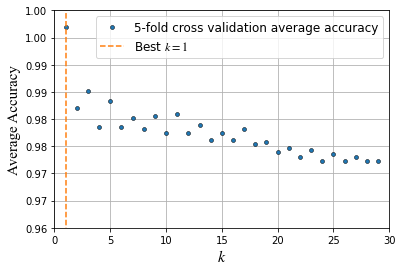

In [40]:
k_space = np.arange(1, 30)
best_k, k_scores = choose_best_k(X_folds, y_folds, folds_indexes, k_space)  # Find best hyper-parameter k in range [1, 30]

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(k_space, k_scores, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='5-fold cross validation average accuracy')
plt.plot(np.linspace(best_k, best_k, 100), np.linspace(0.95, 1, 100), '--', label='Best ' r'$k={}$'.format(round(best_k, 0)))
plt.xlabel(r'$k$', fontname='Times New Roman', fontsize=16)
plt.ylabel('Average Accuracy', fontname='Times New Roman', fontsize=15)
plt.legend()
plt.grid()
plt.xlim(0, 30)
plt.ylim(0.96, 1)
plt.show()

**Figure 6:** The average accuracy plotted against a range of $k$ values for the $k$-NN classifier, using 5-fold cross-validation, shown in blue dots. The vertical orange dotted line represents the best value of $k$ (maximum average accuracy), which is obtained at $k=1$.

<a name="q212"></a>

#### Task 2.1.2 [^](#outline)

We now fix this optimised value of $k$ and use it to retrain the classifier on the entire train data and obtain an (in-sample) accuracy score. We also use this value of $k$ to obtain an accuracy score on the test data (out-of-sample), summarised in the table below.

In [41]:
# using the best hyper-parameter k obtained, obtain the accuracy on the training sample data
train_mean_accuracy = score(np.array(X), np.array(y), np.array(X), np.array(y), k=best_k)

# Loading the test data set using the pandas read_csv method into a pandas DataFrame.
df_tumour_test = pd.read_csv('./Data/tumour_test.csv')
if 'Unnamed: 0' in df_tumour_test.columns:
    df_tumour_test = df_tumour_test.drop('Unnamed: 0', 1)
X_class_test = df_tumour_test.iloc[:, 0:30]  # load descriptors into matrix of descriptors
X_test = standardise(X_class_test)
y_test = df_tumour_test.iloc[:, 30]  # load ground truth target variable vector
y_test = [0 if el == 'B' else 1 for el in y_test]  # convert classification from symbolic to numeric B -> 0 and M -> 1

# using the best hyper-parameter k obtained, obtain the accuracy on the test sample data
test_mean_accuracy = score(np.array(X), np.array(y), np.array(X_test), np.array(y_test), k=best_k)

accuracies = pd.DataFrame(np.array([train_mean_accuracy, test_mean_accuracy]), columns=['Mean Accuracies'], index=[['Train', 'Test']])
display(accuracies)

Mean Accuracies
Train             1.00
Test              0.98

The optimal value of the hyper-parameter $k$ obtained was $k=1$, demonstrating that the data is extremely local. The mean accuracy is $1$ for the train data sample, thus all points were predicted successfully, while the test mean accuracy was $0.98$ which is also very high, demonstrating that the classifier generalised very well despite having such a small value of $k$.

<a name="q22"></a>

## 2.2 Random Forest [^](#outline)

Random forests are a collection of *decision trees* which, in the case of classification, are based upon the idea of partitioning the space of descriptors / predictors and deciding the class of a new (unseen) point $\boldsymbol{x}^\text{in}$ according to that partitioning. The decision tree can be summarised by a series of 'splits', each characterised by the descriptor used for the split and a threshold value.

It is often the case that a descriptor space cannot be perfectly partitioned such that all elements of one class are found in each node of a decision tree, so we use a metric akin to a loss function, to determine what is a *good split*. At each split we want to decide the *optimal split* such that we have 'maximal information' from our split, which in this case is quantified using the **cross-entropy**:

$$\text{Cross-Entropy}[\boldsymbol{\pi}(R_\boldsymbol{\alpha})]=\sum_{q=1}^Q \pi_q(R_\boldsymbol{\alpha})\log\left(\frac{1}{\pi_q\left(R_\boldsymbol{\alpha}\right)}\right),$$

where $\pi_q(R_\boldsymbol{\alpha})$ is the probability of being in region $R_\boldsymbol{\alpha}$ and belonging to class $c_q$, and is given by:

$$\pi_q(R_\boldsymbol{\alpha})=\frac{\sum_{i=1}^N \textit{I}\left(\boldsymbol{x}^{(i)} \in R_\boldsymbol{\alpha} \land y^{(i)} \in c_q\right)}{\sum_{i=1}^N \textit{I}\left(\boldsymbol{x}^{(i)} \in R_\boldsymbol{\alpha}\right)}.$$

The cross-entropy is maximal when all probabilities are the same, i.e., we do not gain any information / learn anything from a particular split, thus we want to ***minimise*** the cross-entropy, maximising the information we'll gain from it. Therefore, at each split, we want to select the descriptor $j$ and its threshold $s$ so that we get:

$$\underset{j, \:s}{\text{min}} \ \text{Cross-Entropy}(\boldsymbol{\pi}(R_\boldsymbol{\alpha})).$$

We repeatedly determine 'optimal splits' until we have reached a given maximum depth of thre tree. At that point we have partitioned our descriptor space and can now predict the class of a new point $\boldsymbol{x}^{\text{in}}$ by:
1. Find the area $R_\boldsymbol{\alpha}$ where it belongs: $\boldsymbol{x}^{\text{in}} \in R_\boldsymbol{\alpha}$
2. Obtain $\boldsymbol{\pi}(R_\boldsymbol{\alpha})$
3. Predict the class by looking at the class with the highest probability, i.e., $\hat{y}=\underset{q}{\text{argmax}} \: \boldsymbol{\pi}(R_\boldsymbol{\alpha}(\boldsymbol{x}^{\text{in}}))$

Below are summarised the functions that determine the cross entropy of given labels and their probabilities, the cross-entropy of a given split, finding the feature and its threshold that produce the 'optimal' split, as well as the classification procedure outlined above.

In [42]:
def cross_entropy(y, sample_weights):
    """
    Calculate the cross-entropy for labels.
    Arguments:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (float): the cross-entropy for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    
    # compute the cross entropy, using the probability of each class in each region
    cross_entropy_value = 0
    for label, weight in label_weights.items():
        pi_q = (weight / total_weight)
        if pi_q == 1:
            continue
        else:
            cross_entropy_value += pi_q * np.log(1 / pi_q)

    return cross_entropy_value

In [43]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
        1. equals value, in case `column` is categorical, or
        2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples 
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
        tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)  # set to equal if it is the same class (for categorical)
    else:
        left_mask = (X[:, column] < value)  # set to comparison (less than) if it is a numerical, i.e. separate based on value
  
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

In [44]:
def cross_entropy_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the cross-entropy based on `column` with the split that minimizes the cross-entropy.
    Arguments:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted cross-entropy and the corresponding value used in splitting.
    """
    
    unique_vals = np.unique(X[:, column])
    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    cross_entropy_val, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
    
        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * cross_entropy(y_l, w_l) + p_right * cross_entropy(y_r, w_r)
        if new_cost < cross_entropy_val:
            cross_entropy_val, threshold = new_cost, value
    
    return cross_entropy_val, threshold

In [45]:
def cross_entropy_split(X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (int, float): the best feature index and value used in splitting. 
        If the feature index is None, then no valid split for the current Node.
    """

    # initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_cross_entropy, split_column, split_val = np.inf, None, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        cross_entropy, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)         
        if cross_entropy < min_cross_entropy:
            min_cross_entropy, split_column, split_val = cross_entropy, column, val

    return split_column, split_val

In [46]:
def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    Args:
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
    Returns:
        (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    return max(majority_label, key=majority_label.get)

In [47]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

The above functions are now able to partition a descriptor space by finding the optimal splits that minimise the cross-entropy at each split. However, decision trees tend to overfit to the particular data used to train them. In order to overcome this issue we use two techniques, namely *bootstrap aggregating* and *feature bagging* in order to form ***random forests***. 

With bootstrap aggregation we form $B$ random samples from our training data through random sampling with replacement, thus allowing to potentially have duplicates of some samples or not contain some samples, creating samples different from the original training data. We then form a new decision tree from each of the $B$ samples, obtain a collection of probability vectors $[\boldsymbol{\pi_1^{DT}}, \dots, \boldsymbol{\pi_B^{DT}}]$, where each individual term is:

$$\boldsymbol{\pi_b}=\begin{pmatrix} \pi_{b,1} \\ \vdots \\ \pi_{b,Q} \end{pmatrix},$$

for $Q$ classes. Finally, the aggregate probability vector is obtained by averaging the probability vectors from all samples $\boldsymbol{\pi}=\frac{1}{B}\sum_{b=1}^B \boldsymbol{\pi}_b^{DT}$ and the class is predicted in the same way, by choosing the class with the highest probability $\hat{y} = \: \underset{q}{\text{argmax}} \: \boldsymbol{\pi}$. 

An additional method used to add further randomisation is to randomly select a subset of descriptors to fit each decision tree. Thus, each split can only consider descriptors in the reduced set of descriptors, minimising potential correlated outcomes arising from dominant descriptors. The functions below summarise the processes to form a random forest.

In [48]:
def cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, D).
        y: vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized cross-entropy, the best feature index and value used in splitting.
    """
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)  # choose columns without replacement to form splits
    columns_dict = {c: columns_dict[c] for c in columns}

    min_cross_entropy, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
   
        # search for the best splitting value for the given column.
        cross_entropy, val = cross_entropy_split_value(X, y, sample_weights, column, categorical)      
        if cross_entropy < min_cross_entropy:
            min_cross_entropy, split_column, split_val = cross_entropy, column, val

    return min_cross_entropy, split_column, split_val

In [49]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=2):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, D).
        y: (np.array) vector of training labels, of shape (N,).
        sample_weights: weights for each samples, of shape (N,).
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
        Example:
            mytree = {
                'feature_name': 'petal length (cm)',
                'feature_index': 2,
                'value': 3.0,
                'categorical': False,
                'majority_label': None,
                'left': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'majority_label': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
                'right': {
                    'feature_name': str,
                    'feature_index': int,
                    'value': float,
                    'categorical': bool,
                    'majority_label': None,
                    'left': {..etc.},
                    'right': {..etc.}
                }
            }
    """
    
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}
  
    else:
        # choose the best feature to split by using the cross-entropy as the criterion
        cross_entropy, split_index, split_val = cross_entropy_split_rf(n_features, X, y, sample_weights, columns_dict)
    
        # If cross_entropy is infinity, it means that samples are not seperable by the sampled features.
        if cross_entropy == np.inf:
            return {'majority_label': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_index]
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
        
        # create a decision tree by adding branches, where the left and right branches recursively call the same function to create more
        # branches until the maximum depth or minimum number of samples in a leaf is reached
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [50]:
def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None, depth=1):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    # check if type of the vector y is already a numpy array to avoid run-time error
    if type(y).__module__ != np.__name__:
        y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        # looping through the number of trees, building a new tree and adding it to the list of trees (forest)
        # where the number of features and the depth is varied
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, depth=depth)
        trees.append(tree)

    return trees

In [51]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

In [52]:
def rf_score(rf, X_test, y_test):
    # rf: a trained random forest
    # X_test: (np.array) testing features, of shape (N, D).
    # y_test: (np.array) vector of testing labels, of shape (N,).
    
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)  # accuracy

<a name="q221"></a>

#### Task 2.2.1 [^](#outline)

Just as we tuned the penalty terms in the regression tasks and the $k$ hyper-parameter in the $k$-NN classifier, we want in this case to optimise two hyper-parameter: the number of decision trees $B$ and the depth of trees $d$. We do this with a grid search T-fold cross-validation, varying all $B$ values for all possible $d$ values, computing the average accuracy of the random forest over the T folds. The optimum hyper-parameters are the set of $B$ and $d$ that maximise (together) the average accuracy.

In [53]:
from collections import defaultdict

def rf_cross_validation_score(X_train, y_train, folds, B, d, n_features):
    # X_train: (np.array) training features, of shape (N, D).
    # y_train: (np.array) vector of training labels, of shape (N,).
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # B: number of trees in the forest
    # d: depth of decision tree
    
    scores = []  # initialise array to hold score (accuracy) for each tree
    for i in range(len(folds)):
        val_indexes = folds[i]
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        # X and y data used for training
        X_train_i = X_train.iloc[train_indexes, :]
        y_train_i = y_train[train_indexes]

        # X and y data used for validation
        X_val_i = X_train.iloc[val_indexes, :]
        y_val_i = y_train[val_indexes]

        # obtain a random forrest with given hyper-parameters B (number of trees in forest) and d (depth of decision tree)
        rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, depth=d)
        score_i = rf_score(rf, X_val_i.to_numpy(), y_val_i)
        scores.append(score_i)

    # Return the average score
    return sum(scores) / len(scores)

In [54]:
def choose_best_hyperparams(X_train, y_train, folds, B_range, d_range, n_features):
    # X_train: matrix containing the training descriptor variables, dimensions: N x p
    # y_train: vector containing class of outcome for training data, dimensions: N x 1
    # folds: a list of the 5 index arrays, dimensions: 5 x N/5
    # B_range: (np.array) a range of B (number of trees in a forest) to test
    # d_range: (np.array) a range of d (depth of decision tree) to test
    
    B_and_d_scores = np.zeros((len(B_range),len(d_range)))  # initialise the scores for each k in k_range
    
    for i, B in enumerate(B_range):
        for j, d in enumerate(d_range):
            # obtain score (accuracy) for given hyper-parameter combination
            B_and_d_scores[i][j] = rf_cross_validation_score(X_train, y_train, folds, int(B), d, n_features)
            print(f'Accuracy@B={B}&d={d}: {B_and_d_scores[i][j]:.3f}')

    # best hyper-parameters B and d are the ones that maximise the score (accuracy)
    best_B_and_d_index = np.argmax(B_and_d_scores)
    return B_range[best_B_and_d_index//B_range.shape[0]], d_range[best_B_and_d_index%B_range.shape[0]], B_and_d_scores

We 'scan' a range of $d$'s in the range $[3, 10]$ and a range of $B$'s in the range $[3, 10]$ and plot the average accuracy. The best set of $B$ and $d$ hyper-parameters is the one that results in the maximum average accuracy, which can be seen below in *Figure 7*.

Accuracy@B=1.0&d=1.0: 0.966
Accuracy@B=1.0&d=2.0: 0.971
Accuracy@B=1.0&d=3.0: 0.971
Accuracy@B=1.0&d=4.0: 0.968
Accuracy@B=2.0&d=1.0: 0.963
Accuracy@B=2.0&d=2.0: 0.972
Accuracy@B=2.0&d=3.0: 0.968
Accuracy@B=2.0&d=4.0: 0.971
Accuracy@B=3.0&d=1.0: 0.981
Accuracy@B=3.0&d=2.0: 0.981
Accuracy@B=3.0&d=3.0: 0.982
Accuracy@B=3.0&d=4.0: 0.977
Accuracy@B=4.0&d=1.0: 0.980
Accuracy@B=4.0&d=2.0: 0.981
Accuracy@B=4.0&d=3.0: 0.978
Accuracy@B=4.0&d=4.0: 0.979


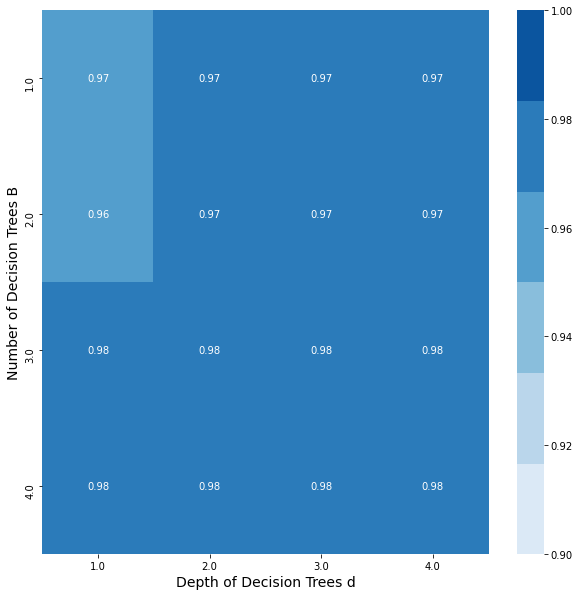

In [55]:
y = np.array(y).astype(int)
training_weights = np.ones_like(y)/len(y)  # assign equal weights for all 
# We need a dictionary indicating whether the column index maps to a 
# categorical feature or numerical
# In this example, all features are numerical (categorical=False)
columns_dict = {index: False for index in range(X.shape[1])}
n_features = X.shape[1] // 3

# X_copy_df = X.drop([X.shape[0]-1])
B_range = np.linspace(1, 4, 4)  # range of hyper-parameter B (number of trees in a forest) to consider
d_range = np.linspace(1, 4, 4)  # range of hyper-parameter d (depth of decision tree) to consider

# perform 5-fold cross-validation to obtain best combination of hyper-parameters B and d
best_B, best_d, B_and_d_scores = choose_best_hyperparams(X_copy, np.array(y_copy), folds_indexes, B_range, d_range, n_features)

import seaborn as sns
x_axis_labels = B_range
y_axis_labels = d_range
fig, ax = plt.subplots(figsize=(10, 10))
color = sns.color_palette("Blues")
s = sns.heatmap(B_and_d_scores, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax, cmap=color, vmin=0.9, vmax=1, annot=B_and_d_scores)
s.set_xlabel('Depth of Decision Trees d', fontsize=14)
s.set_ylabel('Number of Decision Trees B', fontsize=14)
plt.show()

**Figure 7:** Heatmap of the average accuracy for different combinations of total number of trees $B$ and depth of decision trees $d$ in each random forest during the T-fold cross-validation. The optimal combination of $B$ and $d$ that maximised the average accuracy were: $B=3$ and $d=3$.

<a name="q222"></a>

#### Task 2.2.2 [^](#outline)

We now fix these optimised hyper-parameters of $B$ and $d$ and use them to retrain the classifier on the entire train data and obtain an (in-sample) accuracy, recall, precision & F1-score. We also use these values of $B$ and $d$ to obtain an accuracy, recall, precision & F1-score on the test data (out-of-sample), summarised in the table below.

In [56]:
def recall(y_true, y_pred):
    # true positives
    tp = np.sum([1 if (y_t == 1 and y_p == 1) else 0 for y_t, y_p in zip(y_true, y_pred)])
    # false negatives
    fn = np.sum([1 if (y_t == 1 and y_p == 0) else 0 for y_t, y_p in zip(y_true, y_pred)])
    
    return tp / (tp + fn)


def precision(y_true, y_pred):
    # true positives
    tp = np.sum([1 if (y_t == 1 and y_p == 1) else 0 for y_t, y_p in zip(y_true, y_pred)])
    # false positives
    fp = np.sum([1 if (y_t == 0 and y_p == 1) else 0 for y_t, y_p in zip(y_true, y_pred)])
    
    return tp / (tp + fp)


def f1_score(y_true, y_pred):
    # recall score
    rc = recall(y_true, y_pred)
    # precision score
    pr = precision(y_true, y_pred)
    
    return 2 * (pr * rc) / (pr + rc)  # F1-score

In [57]:
# train a random forest using the obtained optimal hyper-parameters B and d
rf_train_sample = train_rf(int(best_B), X.shape[1] // 3, X, y, columns_dict, depth=int(best_d))

In [58]:
y_pred = predict_rf(rf_train_sample, X.to_numpy())

accuracy_train = rf_score(rf_train_sample, X.to_numpy(), y)
recall_train = recall(y, y_pred)
precision_train = precision(y, y_pred)
f1_score_train = f1_score(y, y_pred)
train_df = pd.DataFrame(np.array([accuracy_train, recall_train, precision_train, f1_score_train]), columns=['Random Forest - Train Data'], index=[['Accuracy', 'Recall', 'Precision', 'F1-Score']])

# predict the class y using the random forest, for the test data
y_pred_test = predict_rf(rf_train_sample, X_test.to_numpy())

accuracy_test = rf_score(rf_train_sample, X_test.to_numpy(), y_test)
recall_test = recall(y_test, y_pred_test)
precision_test = precision(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)
test_df = pd.DataFrame(np.array([accuracy_test, recall_test, precision_test, f1_score_test]), columns=['Random Forest - Test Data'], index=[['Accuracy', 'Recall', 'Precision', 'F1-Score']])

display(pd.concat([train_df, test_df], axis=1))

Random Forest - Train Data  Random Forest - Test Data
Accuracy                     0.992985                   0.880000
Recall                       0.959906                   0.671233
Precision                    0.997549                   1.000000
F1-Score                     0.978365                   0.803279

We can observe that the accuracy for the train data is $\approx 0.99$, while for the test data it is $\approx 0.89$, demonstrating that the random forest is more accurate on the training data than the test data, as expected. However, accuracy is not a good metric, because the data is heavily unbalanced, with 83% of the samples being in one class (benign), so even if the classifier always predicted samples as benign it would have an 83% accuracy. On the other hand, the recall of the train data is a better metric as it looks at how many positives are correctly guessed, which is more important in the case of tumour classification. The recall of the test data is $\approx 0.96$, while the recall of the test data is $\approx 0.71$ showing that the classifier loses some of its generalisability with unseen data, however, it is not very low considering the imbalance of the data. The precision of the train data is $\approx 0.98$ and the precision of the test data is $0.98$, which again demonstrates the imbalance of the data - because most of the data is benign, the classifier predicts almost all of the true negatives correctly (even slightly better for the test data than the train data). Finally, the F1-score, being a harmonic mean between the recall and the precision, is $\approx 0.97$ for the train data and $\approx 0.83$ for the test data demonstrating as expected, that on balance, the classifier is better at predicting the train data than the test data. Overall, an F1 of $\approx 0.83$ on unseen data is relatively good, considering, again, the large data imbalance.

<a name="q23"></a>

## 2.3 Support Vector Machine (SVM) [^](#outline)

Suppor Vector Machines (SVMs) are aiming at solving classification problems in a geometrical way. The main idea is to define a hyperplane that separates the data samples according to their binary class. When it is impossible to fully separate the samples with a hyperplane, we employ soft-margin SVMs, using a *hinge loss* function, as follows: 

$$\zeta^{(i)}=\text{max} \{0, 1-(\boldsymbol{x}^{(i)}\cdot \boldsymbol{w}+b)y^{(i)})\}$$

The goal is to minimise this loss function: $$\underset{\boldsymbol{w}}{min} \frac{1}{2} \|\boldsymbol{w}\|^2 + \lambda \sum_{i=1}^N \zeta^{(i)}$$ subject to $1-y^{(i)}(\boldsymbol{w} \cdot \boldsymbol{x}^{(i)} + b) \le \zeta^{(i)} \quad \text{for} \: i=1, \dots, N,$ where $\boldsymbol{w}$ is the vector of weights.

The way we achieve this optimisation problem is through stochastic gradient descent. We define two functions below, to be used in the stochastic gradient descent, in order to iteratively update the weights using some learning rate $\alpha$. Moreover, we will be stopping the gradient descent when the cost function has not changed by more than 1% (0.01). The learning occurs by updating each time the weights as such: $\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}$, where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss.

In [59]:
def compute_cost(w, X, y, regul_strength=1e5):
    # w: vector of weights
    # X:  matrix containing the descriptor variables, dimensions: N x p (including the intercept 1s)
    # y: vector containing class of outcome, dimensions: N x 1
    # regul_strength: the regularisation parameter
    
    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean()  # compute hinge loss value

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

In [60]:
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    # w: vector of weights
    # X_batch:  matrix containing the descriptor variables, dimensions: N x p (including the intercept 1s)
    # y_batch: vector containing class of outcome, dimensions: N x 1
    # regul_strength: the regularisation parameter
    
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw/len(y_batch)  # average

In [61]:
def sgd(X, y, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-4, regul_strength=401, print_outcome=False):
    # X:  matrix containing the descriptor variables, dimensions: N x p (including the intercept 1s)
    # y: vector containing class of outcome, dimensions: N x 1
    # batch_size: 
    # max_iterations: maximum number of iterations
    # stop_criterion: manually ends the stochastic gradient descent when the hinge loss hasn't changed by 1%
    # learning_rate: learning rate of updating weights
    # regul_strength: the regularisation parameter
    # print_outcome: boolean on whether to print or not the outcome
    
    
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength)
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength)
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

<a name="q231"></a>

#### Task 2.3.1 [^](#outline)

As we have tuned penalty terms and other hyper-parameters, we want in this case to optimise the hardness hyper-parameter which regulates the boundary violation penalty. We do this again through T-fold cross-validation, varying the hardness hyper-parameter $\lambda$, computing the average accuracy over the T folds. The optimum hyper-parameter $\lambda$ is the one that maximises the average accuracy.

In [62]:
def score(w, X, y):
    # w: vector of weights
    # X:  matrix containing the descriptor variables, dimensions: N x p (including the intercept 1s)
    # y: vector containing class of outcome, dimensions: N x 1
    
    y_preds = np.sign(X @ w)
    return np.mean(y_preds == y)  # accuracy

In [63]:
def cross_val_evaluate(X, y, folds, lambd=0):
    # folds = cross_val_split(data.shape[0], num_folds)

    train_scores = []
    val_scores = []
    for i in range(len(folds)):
        # print('Fold', i+1)

        val_indices = folds[i]
        # define the training set
        train_indices = list(set(range(y.shape[0])) - set(val_indices))

        X_train = X[train_indices,  :]
        y_train = y[train_indices]
        
        # define the validation set
        X_val = X[val_indices,  :]
        y_val = y[val_indices]

        # train the model
        w = sgd(X_train, y_train, batch_size=32, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-5, regul_strength=lambd)

        # evaluate
        train_score = score(w, X_train, y_train)
        val_score = score(w, X_val, y_val)
        # print("Accuracy on train set #{}: {}".format(i+1, train_score))
        # print("Accuracy on validation set #{}: {}".format(i+1, val_score))

        train_scores.append(train_score)
        val_scores.append(val_score)

    return np.mean(val_scores), np.mean(train_scores)

In [64]:
def choose_best_lambd(X, y, folds, lambd_range):
    lambd_scores = np.zeros((len(lambd_range),))
    scores = []
    for i, l in enumerate(lambd_range):
        score = cross_val_evaluate(X, y, folds, lambd=l)[0]
        lambd_scores[i] = score

    best_lambd_index = np.argmax(lambd_scores)
    
    return lambd_range[best_lambd_index], lambd_scores

We reload the train and test data from the original file, in order to restructure it, adding a column named 'intercept' with entries of $1$'s.

In [65]:
X_class = df_tumour_samples.iloc[:, 0:30]  # load descriptors into matrix of descriptors
X = standardise(X_class)
if 'intercept' not in X.columns:
    X.insert(loc=len(X.columns) , column='intercept', value=1)  # add a column of 1s for the constant weight term, w_0
X['intercept'] = np.ones((X.shape[0]))
y = df_tumour_samples.iloc[:, 30]  # load ground truth target variable vector
y = np.array([1 if el == 'M' else -1 for el in y])  # convert classification from symbolic to numeric M -> 1 and B -> -1
y = y.astype(float)

X_class_test = df_tumour_test.iloc[:, 0:30]  # load descriptors into matrix of descriptors
X_test = standardise(X_class_test)
if 'intercept' not in X_test.columns:
    X_test.insert(loc=len(X_test.columns) , column='intercept', value=1)  # add a column of 1s for the constant weight term, w_0
X_test['intercept'] = np.ones((X_test.shape[0]))
y_test = df_tumour_test.iloc[:, 30]  # load ground truth target variable vector
y_test = np.array([1 if el == 'M' else -1 for el in y_test])
y_test = y_test.astype(float)

We 'scan' a range of $\lambda$'s in the range $[0, 1000]$ and plot the average accuracy. The best hyper-parameter $\lambda$ is the one that results in the maximum average accuracy, which can be seen below in *Figure 8*.

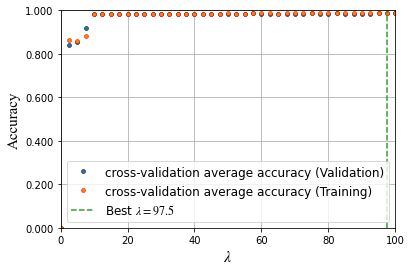

In [66]:
lambd_range = np.linspace(0, 100, 41)
best_lambda, lambda_scores = choose_best_lambd(X.to_numpy(), y, folds_indexes, lambd_range)
training_scores = [cross_val_evaluate(X.to_numpy(), y, folds_indexes, lambd=l)[1] for l in lambd_range]

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(lambd_range, lambda_scores, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='cross-validation average accuracy (Validation)')
plt.plot(lambd_range, training_scores, 'o', markeredgecolor='r', markersize=4, markeredgewidth=0.5, label='cross-validation average accuracy (Training)')
plt.plot(np.linspace(best_lambda, best_lambda, 100), np.linspace(0, 1, 100), '--', label='Best ' r'$\lambda={}$'.format(best_lambda))
plt.ylim(0, 1)
plt.xlim(min(lambd_range), max(lambd_range))
plt.xlabel(r'$\lambda$', fontname='Times New Roman', fontsize=16)
plt.ylabel('Accuracy', fontname='Times New Roman', fontsize=15)
plt.grid()
plt.legend()
plt.show()

**Figure 8:** The average accuracy plotted against a range of $\lambda$ values for the soft-margin SVM, using 5-fold cross-validation, shown in blue dots (validation) and red dots (training). The vertical orange dotted line represents the best value of $\lambda$ (maximum average accuracy), which is obtained at $\lambda=97.5$.

Firstly, we notice a slightly higher average accuracy on the training data than the validation, as expected. The accuracy of the SVM is 0 for $\lambda=0$ and very quickly increases through small hardness hyper-parameter values, as at low values of $\lambda$ violations are not penalised significantly and hence, the SVM does not separate data very well. As the $\lambda$ increases, and the boundaries become 'harder', large violations are not allowed, which explains the increase in the average accuracy, and in the large limit of $\lambda$ it becomes a hard-margin SVM.

<a name="q232"></a>

#### Task 2.3.2 [^](#outline)

We now fix this optimised hardness hyper-parameters $\lambda$ and use it to retrain the soft-margin SVM on the entire train data and obtain an (in-sample) accuracy. We also use this optimised hardness hyper-parameters $\lambda$ to obtain an accuracy on the test data (out-of-sample), summarised in the table below.

In [67]:
w = sgd(X.to_numpy(), y, batch_size=32, max_iterations=5000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=70, print_outcome=False)
score_train = score(w, X, y)
score_test = score(w, X_test.to_numpy(), y_test)

accuracies = pd.DataFrame(np.array([score_train, score_test]), columns=['Mean Accuracies'], index=[['Train', 'Test']])
display(accuracies)

Mean Accuracies
Train          0.98714
Test           0.90000

We can see that the mean accuracy is higher in the train data than the test data, as expected, however, another way to display the performance of the soft-margin SVM is to obtain a *receiver operating characteristic (ROC)* curve. The ROC curve is summarised below, by obtaining the true positivity and false positivity learning rates.

In [68]:
def roc_curve(X, y, lambda_range):
    
    tpr_l = []  # instantiation of the true positivity rate learning
    fpr_l = []  # instantiation of the false positivity rate learning
    
    for l in lambda_range:  # scanning through different values of the hardness hyper-parameter \lambda
        # obtaining the updated weights from the stochastic gradient descent
        w = sgd(X, y, batch_size=32, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-5, regul_strength=l)
        # obtaining a prediction using the weights
        y_pred = predict_SVM(X, w)
        
        # true positives
        tp = np.sum([1 if (y_t == 1 and y_p == 1) else 0 for y_t, y_p in zip(y, y_pred)])
        # false negatives
        fn = np.sum([1 if (y_t == 1 and y_p == -1) else 0 for y_t, y_p in zip(y, y_pred)])
        # false positives
        fp = np.sum([1 if (y_t == -1 and y_p == 1) else 0 for y_t, y_p in zip(y, y_pred)])
        # true negatives
        tn = np.sum([1 if (y_t == -1 and y_p == -1) else 0 for y_t, y_p in zip(y, y_pred)])
     
        tpr = tp / (tp + fn)  # obtaining the true positive rate
        fpr = fp / (tn + fp)  # obtaining the false positive rate
        
        tpr_l.append(tpr)
        fpr_l.append(fpr)
        
    # area under curve from ROC curve
    auc = np.trapz(tpr_l, fpr_l)
    
    return auc, tpr_l, fpr_l

In [69]:
def predict_SVM(X, w):
    # making a prediction using the obtained weights from the stochastic gradient descent
    return np.sign(X@w)

Initially, we predict the target variable for the test data, using the obtained weights, and then we compare to the ground truth target variable to obtain the ROC curve, depicted below in *Figure 9*.

/tmp/ipykernel_78336/2833003362.py:21: RuntimeWarning: invalid value encountered in long_scalars
  tpr = tp / (tp + fn)  # obtaining the true positive rate
/tmp/ipykernel_78336/2833003362.py:22: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fp / (tn + fp)  # obtaining the false positive rate


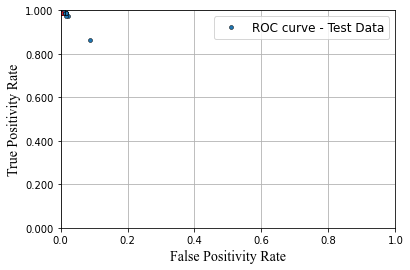

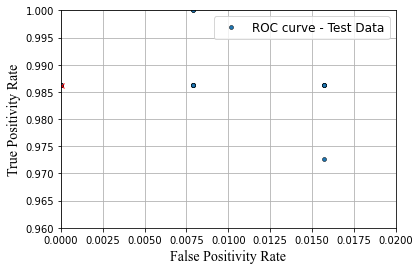

In [70]:
lambd_range = np.linspace(0, 100, 41)
auc, tpr_l, fpr_l = roc_curve(X_test.to_numpy(), y_test, lambd_range)

best_point_x = np.array(fpr_l)[np.where(lambd_range==best_lambda)][0]
best_point_y = np.array(tpr_l)[np.where(lambd_range==best_lambda)][0]

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(fpr_l, tpr_l, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='ROC curve - Test Data')
plt.plot(best_point_x, best_point_y, 'x', markersize=4, color='red')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.ylabel('True Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.grid()
plt.legend()
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(fpr_l, tpr_l, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='ROC curve - Test Data')
plt.plot(best_point_x, best_point_y, 'x', markersize=5, color='red')
plt.xlim(0, 0.02)
plt.ylim(0.96, 1)
plt.xlabel('False Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.ylabel('True Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.grid()
plt.legend()
plt.show()

**Figure 9:** ROC curve about the soft-margin SVM classifier, varying the hardness hyper-parameter, by applying each to the test data. The red cross represents the point on the ROC curve resulted from the obtained optimised hardness hyper-parameter, $\lambda=70$. Second plot is the same as the first, zoomed in on the corner $(0, 1)$ in order to better inspect the point produced with the optimised hardness hyper-parameter $\lambda=70$.

The ideal ROC curve would be at 0 false positivity rate and 1 true positivity rate. The optimal hardness hyper-parameter is the one that is closest to the $(0, 1)$ point on the plot in *Figure 9*, shown by a red cross, having the lowest false positivity rate and the highest true positivity rate. The hardness hyper-parameter that resulted in the point closest to $(0, 1)$ was $\lambda=70$. This demonstrates that the optimal hardness hyper-parameter obtained in Task 2.3.1 has the best balance between false positivity rate and true positivity rate compared to other $\lambda$'s, as shown in *Figure 9*.

<a name="q233"></a>

#### Task 2.3.3 [^](#outline)

Finally, we repeat Task 2.3.1 and Task 2.3.2, but trained on the balanced data set found in `./Data/tumour_samples_bal.csv`.

In [71]:
# Loading the balanced sample data set using the pandas read_csv method into a pandas DataFrame.
df_tumour_samples_bal = pd.read_csv('./Data/tumour_samples_bal.csv')

# the if-statement ensures this is only done once, at the beginning (in case someone wants to refresh the Pandas DataFrame)
if 'Unnamed: 0' in df_tumour_samples_bal.columns:
    df_tumour_samples_bal = df_tumour_samples_bal.drop('Unnamed: 0', 1)  # we remove the 'wrong' column from the data set
# We obtain an array of the data-type of all columns
data_type = np.array([df_tumour_samples_bal.dtypes[i] for i in range(df_tumour_samples_bal.shape[1]-1)])
assert(data_type.all() == float)  # we assert that all columns are of type float
assert(df_tumour_samples_bal.isnull().values.any() == False)  # we assert that there is no empty / NaN entry in any column

X_class_bal = df_tumour_samples_bal.iloc[:, 0:30]  # load descriptors into matrix of descriptors
X_bal = standardise(X_class_bal)
if 'intercept' not in X_bal.columns:
    X_bal.insert(loc=len(X_bal.columns) , column='intercept', value=1)  # add a column of 1s for the constant weight term, w_0
X_bal['intercept'] = np.ones((X_bal.shape[0]))
y_bal = df_tumour_samples_bal.iloc[:, 30]  # load ground truth target variable vector
y_bal = np.array([1 if el == 'M' else -1 for el in y_bal])  # convert classification from symbolic to numeric M -> 1 and B -> -1
y_bal = y_bal.astype(float)

We 'scan' a range of $\lambda$'s in the range $[0, 1000]$ and plot the average accuracy. The best hyper-parameter $\lambda$ is the one that results in the maximum average accuracy, which can be seen below in *Figure 10*.

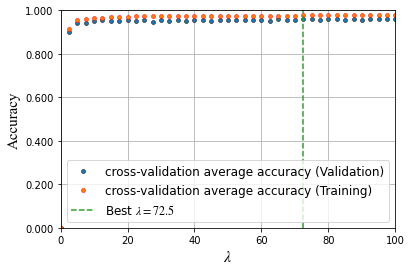

In [72]:
lambd_range_bal = np.linspace(0, 100, 41)

X_bal_copy = np.array(X_bal.copy())  # Copying the variable to use for folds, in order to not affect the original variable
y_bal_copy = y_bal.copy()  # Copying the variable to use for folds, in order to not affect the original variable

np.random.seed(10)  # fixing the random seed to make the results reproducible
p = np.random.permutation(len(y_bal_copy))  # shuffling the data for even greater generalisability
X_folds_bal = X_bal_copy[p]
y_folds_bal = y_bal_copy[p]

# We obtain a list of the 5 index arrays, i.e., the 5 folds
folds_indexes_bal = np.split(np.arange(len(y_folds_bal)), 5)

best_lambda_bal, lambda_scores_bal = choose_best_lambd(X_bal.to_numpy(), y_bal, folds_indexes_bal, lambd_range_bal)
training_scores_bal = [cross_val_evaluate(X_bal.to_numpy(), y_bal, folds_indexes_bal, lambd=l)[1] for l in lambd_range_bal]

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(lambd_range_bal, lambda_scores_bal, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='cross-validation average accuracy (Validation)')
plt.plot(lambd_range_bal, training_scores_bal, 'o', markeredgecolor='r', markersize=4, markeredgewidth=0.5, label='cross-validation average accuracy (Training)')
plt.plot(np.linspace(best_lambda_bal, best_lambda_bal, 100), np.linspace(0, 1, 100), '--', label='Best ' r'$\lambda={}$'.format(best_lambda_bal))
plt.ylim(0, 1)
plt.xlim(min(lambd_range_bal), max(lambd_range_bal))
plt.xlabel(r'$\lambda$', fontname='Times New Roman', fontsize=16)
plt.ylabel('Accuracy', fontname='Times New Roman', fontsize=15)
plt.grid()
plt.legend()
plt.show()

**Figure 10:** The average accuracy plotted against a range of $\lambda$ values for the soft-margin SVM, using 5-fold cross-validation, shown in blue dots (validation) and red dots (training). The vertical orange dotted line represents the best value of $\lambda$ (maximum average accuracy), which is obtained at $\lambda=72.5$.

We now fix this optimised hardness hyper-parameters $\lambda$ and use it to retrain the soft-margin SVM on the entire train data and obtain an (in-sample) accuracy.

In [73]:
w_bal = sgd(X_bal.to_numpy(), y_bal, batch_size=32, max_iterations=5000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=70, print_outcome=False)
score_bal = score(w_bal, X_bal, y_bal)

accuracies_bal = pd.DataFrame(np.array([score_bal]), columns=['Mean Accuracies'], index=[['Balanced Data']])
display(accuracies_bal)

Mean Accuracies
Balanced Data          0.97875

The mean accuracy of the balanced data ($0.97875$) is lower than that of the training data ($0.987$), demonstrating the extent to which the imbalance of data (the class distribution) affects metrics like accuracy. Having balanced data slightly decreased the accuracy.

Initially, we predict the target variable for the test data, using the obtained weights, and then we compare to the ground truth target variable to obtain the ROC curve, depicted below in *Figure 11*.

/tmp/ipykernel_78336/2833003362.py:21: RuntimeWarning: invalid value encountered in long_scalars
  tpr = tp / (tp + fn)  # obtaining the true positive rate
/tmp/ipykernel_78336/2833003362.py:22: RuntimeWarning: invalid value encountered in long_scalars
  fpr = fp / (tn + fp)  # obtaining the false positive rate


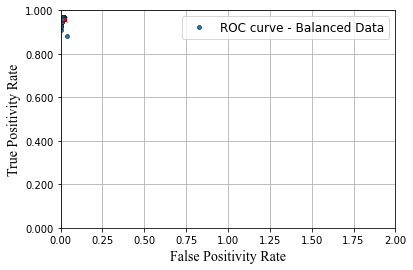

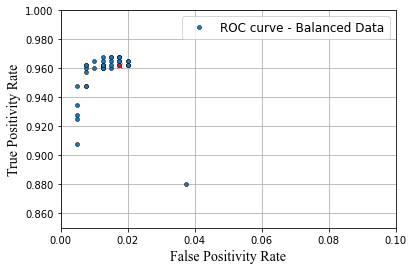

In [74]:
lambd_range_bal = np.linspace(0, 100, 41)
auc_bal, tpr_l_bal, fpr_l_bal = roc_curve(X_bal.to_numpy(), y_bal, lambd_range_bal)

best_point_x_bal = np.array(fpr_l_bal)[np.where(lambd_range_bal==best_lambda_bal)][0]
best_point_y_bal = np.array(tpr_l_bal)[np.where(lambd_range_bal==best_lambda_bal)][0]

from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(fpr_l_bal, tpr_l_bal, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='ROC curve - Balanced Data')
plt.plot(best_point_x_bal, best_point_y_bal, 'x', markersize=5, color='red')
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.xlabel('False Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.ylabel('True Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.grid()
plt.legend()
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(fpr_l_bal, tpr_l_bal, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='ROC curve - Balanced Data')
plt.plot(best_point_x_bal, best_point_y_bal, 'x', markersize=5, color='red')
plt.xlim(0, 0.1)
plt.ylim(0.85, 1)
plt.xlabel('False Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.ylabel('True Positivity Rate', fontname='Times New Roman', fontsize=14)
plt.grid()
plt.legend()
plt.show()

**Figure 11:** ROC curve about the soft-margin SVM classifier, varying the hardness hyper-parameter, by applying each to the balanced data. Second plot is the same as the first, zoomed in on the corner $(0, 1)$ in order to better inspect the point produced with the optimised hardness hyper-parameter $\lambda=72.5$.

The ROC curve obtained from the balanced data shown in *Figure 11* is not 'better' than the ROC curve obtained from the test data shown in *Figure 9*, in fact, it has slightly higher false positivity rate and marginally lower true positivity rate. This demonstrates that the false positivity rate is lower in the test data because of the big imbalance (many more negative than positive samples), resulting in very low false positives. However, when the data is balanced this effect disappears and the false positivity rate can increase, as it did.

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Logistic Regression and Bagging [^](#outline)

Logistic regression is used for classification of binary classification and uses the logistic equation: $f(x) = \frac{1}{1+e^{-x}}$, summarised below. We learn parameters in the same way as in linear regression, but then pass the result to the logistic function:
$$\hat{\boldsymbol y}_{\text{log}} = f(\boldsymbol \beta^T \boldsymbol X + \beta_0),$$

which provides a value between 0 and 1, i.e., a probability of the input belonging to one of the two classes.

In [75]:
def logistic(x):
    return 1. / (1. + np.exp(-x))

In [76]:
def predict_log(X, beta, beta_0):
    y_log = logistic(X.T @ beta + beta_0)
    return y_log.squeeze()

In [77]:
def initialise(d):
    """    
    Argument:
    d: size of the beta vector (or number of parameters)
  
    Returns:
    beta: initialised vector of shape (d, 1)
    beta_0: initialised scalar (corresponds to the offset)
    """
  
    beta = np.zeros(shape=(d, 1), dtype=np.float32)
    beta_0 = 0
  
    assert(beta.shape==(d, 1))
    assert(isinstance(beta_0, float) or isinstance(beta_0, int))
  
    return beta, beta_0

We can estimate the parameters of logistic regression by minimising the negative log-likelihood, given by:

$$
\mathcal L = - \frac{1}{n} \sum_{i=1}^n y^{(i)} \log(\hat{y}_{\text{log}}^{(i)}) + (1-y^{(i)}) \log (1-\hat{y}_{\text{log}}^{(i)}) \, .
$$
This can be achieved through gradient descent, where the derivatives are taken with respect to $\boldsymbol \beta$ and $\beta_0$ are:
$$
\frac{\partial \mathcal L}{\partial \boldsymbol \beta} = \frac{1}{n} \sum_{i=1}^n X^{(i)} (\hat{y}_{\text{log}}^{(i)} - y^{(i)})^T
$$
 
$$
\frac{\partial \mathcal L}{\partial \beta_0} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_{\text{log}}^{(i)} - y^{(i)})
$$


In [78]:
def propagate(X, y, beta, beta_0):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns:
    cost: negative log-likelihood cost for logistic regression
    dbeta: gradient of the loss with respect to beta
    dbeta_0: gradient of the loss with respect to beta_0
    """
    n = X.shape[1]
    y_log = predict_log(X, beta, beta_0)

    # cost function
    cost = - (y * np.log(y_log) + (1-y) * np.log(1 - y_log)).mean()

    # derivatives
    dbeta = (X * (y_log - y)).mean(axis=1).reshape(-1, 1)
    dbeta_0 =  (y_log - y).mean()  ## <-- SOLUTION

    assert(dbeta.shape==beta.shape)
    assert(dbeta_0.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())
  
    # store gradients in a dictionary
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
    return grads, cost

In [79]:
def optimise(X, y, beta, beta_0, num_iterations=1000, learning_rate=0.005, print_cost=False):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar
    num_iterations: number of iterations gradient descent shall update the parameters
    learning_rate: step size in updating procedure
    print_cost: whether to print the cost every 100 iterations or not

    Returns:
    params: dictionary containing the parameters beta and offset beta_0
    grads: dictionary containing the gradients
    costs: list of all the costs computed during the optimisation (can be used to plot the learning curve).
    """
    costs = []
    
    for i in range(num_iterations):

        # calculate cost and gradients (hint: use your existing functions)
        grads, cost = propagate(X, y, beta, beta_0)
      
        # retrieve derivatives from grads
        dbeta = grads["dbeta"]
        dbeta_0 = grads["dbeta_0"]
      
        # updating procedure
        beta = beta - learning_rate * dbeta
        eta_0 = beta_0 - learning_rate * dbeta_0
      
        # record the costs
        if i % 100 == 0:
            costs.append(cost)
      
        # print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("cost after iteration %i: %f" %(i, cost))
  
    # save parameters and gradients in dictionary
    params = {"beta": beta, "beta_0": beta_0}
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}
  
    return params, grads, costs

In [80]:
def predict(X_test, beta, beta_0):
    """
    Arguments:
    X_test: test data of size (d, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns:
    y_pred: vector containing all binary predictions (0/1) for the examples in X_test
    """
    n = X_test.shape[1]
    y_pred = np.zeros((1,n))
    beta = beta.reshape(X_test.shape[0], 1)
  
    # compute vector y_log predicting the probabilities
    y_log = predict_log(X_test, beta, beta_0)
  
    # decision threshold is automatically set to 0.5 (this is how the round algorithm rounds)
    y_pred = y_log.round().reshape(1, -1)
  
    assert(y_pred.shape==(1, n))
  
    return y_pred

In [81]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    # initialize parameters with zeros
    beta, beta_0 = initialise(X_train.shape[0])

    # gradient descent
    parameters, grads, costs = optimise(X_train, y_train, beta, beta_0, num_iterations, learning_rate, print_cost=print_cost)

    # retrieve parameters beta and beta_0 from dictionary "parameters"
    beta = parameters["beta"]
    beta_0 = parameters["beta_0"]

    # predict test and train set examples
    y_pred_test = predict(X_test, beta, beta_0)
    y_pred_train = predict(X_train, beta, beta_0)

    # print train/test Errors
    # print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    # print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {"costs": costs, "y_pred_test": y_pred_test, "y_pred_train": y_pred_train, "beta": beta, "beta_0": beta_0, "train_accuracy": 100 - np.mean(np.abs(y_pred_train - y_train)) * 100, "test_accuracy": 100 - np.mean(np.abs(y_pred_test - y_test)) * 100, "learning_rate": learning_rate, "num_iterations": num_iterations}
  
    return d

<a name="q311"></a>

#### Task 3.1.1 [^](#outline)

We now train a logistic regression classifier on the training data set utilising our gradient descent, for $5000$ iterations, with a learning rate of $0.005$ and a decision threshold of $0.5$, i.e., choosing one class when the logistic function returns over $0.5$, and the other when it returns less than $0.5$.

In [82]:
y_log = np.array([1 if el == 1 else 0 for el in y])
y_test_log = np.array([1 if el == 1 else 0 for el in y_test])

d = model(X.to_numpy().T, y_log,  X_test.to_numpy().T, y_test_log, num_iterations=5000, learning_rate=0.005, print_cost=False)

accuracies = pd.DataFrame(np.array([d["train_accuracy"], d["test_accuracy"]]), columns=['Accuracies'], index=[['Train', 'Test']])
display(accuracies)

Accuracies
Train   98.597038
Test    91.500000

<a name="q312"></a>

#### Task 3.1.2 [^](#outline)

Next, we implement bagging to the training of the logistic regression classifier. We create $B$ new samples from our data with replacement, and train a model on each new sample. We perform T-fold cross-validation in order to tune the hyper-parameter $B$, as shown in *Figure 12*.

In [83]:
def bagging(X, y, X_test, y_test, B=10):
    N = X.shape[0]
    training_indices = np.arange(N)  # arrange the indices to choose from original array
    
    logistic_models = []  # array to hold each different model
    # looping through B new samples
    for i in range(B):
        # creating a new sample by drawing random indeces, with replacement
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]  # obtaining the new sample in X
        y_sample = y[sample]  # obtaining the new sample in y
        # learning a model on the specific new sample B
        logistic_model = model(X_sample.T, y_sample,  X_test.T, y_test, num_iterations=5000, learning_rate=0.005, print_cost=False)
        logistic_models.append(logistic_model)  # adding the model to the list of models
        
    return logistic_models

In [84]:
def b_cross_validation_score(X, y, folds, b):
    scores = []  # will hold the accuracy from each T-fold
    
    for i in range(len(folds)):
        validation_fold_indexes = folds[i]
        training_fold_indexes = list(set(range(y.shape[0])) - set(validation_fold_indexes))
        
        # X and y data used for training
        X_training = X[training_fold_indexes, :]
        y_training = y[training_fold_indexes]

        # X and y data used for validation
        X_validation = X[validation_fold_indexes, :]
        y_validation = y[validation_fold_indexes]
        
        # converting the target variables in the correct format for logistic regression
        y_training = np.array([1 if el == 1 else 0 for el in y_training])
        y_validation = np.array([1 if el == 1 else 0 for el in y_validation])
        
        # a series of models is obtained using bootstrap aggregation (bagging)
        models = bagging(X_training, y_training, X_validation, y_validation, B=int(b))
        y_pred = score_B(models)  # the aggregate model solution is obtained here
        
        # accuracy is obtained by counting the correct number of predicted points
        accuracy = (len(y_pred)-np.sum(abs(y_pred - y_validation)))/len(y_pred)
        
        scores.append(accuracy)  # accuracy for each T-fold is saved

    # Return the average score
    return sum(scores) / len(scores)

In [85]:
def choose_best_b(X, y, folds, B_range):
    scores = []
    
    for b in B_range:
        # looping through the different values of B to obtain the accuracies
        scores.append(b_cross_validation_score(X, y, folds, b))
    
    best_score_index = np.argmax(scores)
    return scores, B_range[best_score_index]

In [86]:
def score_B(models):
    # the predicted y values from all ensemble models are collected
    y_pred_test = np.array([models[i]["y_pred_test"][0] for i in range(len(models))])
    # the columns are converted into rows (in order to count the most common predicted value from each model
    y_pred_test_tr = y_pred_test.T

    # the average value is obtained (which if less than 0.5 will be considered 0 and if greater than 0.5 will be considered 1 -> majority vote
    avg_test = np.mean(y_pred_test_tr, axis=1)
    # the averages are rounded, thus keeping the value with the most common occurence, as required
    rounded_test = np.array([round(a) for a in avg_test])

    return rounded_test

In [87]:
b_space = np.linspace(1, 5, 5)
scores_b, best_b = choose_best_b(X.to_numpy(), y, folds_indexes, b_space)

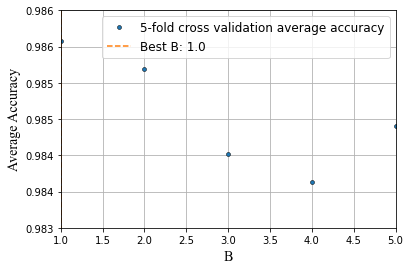

In [88]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
ax.ticklabel_format(useOffset=False)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
plt.plot(b_space, scores_b, 'o', markeredgecolor='k', markersize=4, markeredgewidth=0.5, label='5-fold cross validation average accuracy')
plt.plot(np.linspace(best_b, best_b, 100), np.linspace(0, 1, 100), '--', label='Best B: {}'.format(round(best_b, 1)))
plt.xlabel('B', fontname='Times New Roman', fontsize=14)
plt.ylabel('Average Accuracy', fontname='Times New Roman', fontsize=14)
plt.legend()
plt.grid()
plt.xlim(min(b_space), max(b_space))
plt.ylim(0.983, 0.986)
plt.show()

**Figure 12:** The average accuracy plotted against a range of hyper-parameter $B$ values, using 5-fold cross-validation, shown in blue dots. The vertical orange dotted line represents the best value of $B$ at $B=3$, with a very high accuracy of $0.985$.

<a name="q313"></a>

#### Task 3.1.3 [^](#outline)

We now fix this optimised hyper-parameter $B$ and use it to retrain the model on the entire test data and obtain an (out-of-sample) accuracy score achieved through bagging.

In [235]:
models = bagging(X.to_numpy(), y_log,  X_test.to_numpy(), y_test_log, B=int(best_b))
y_pred_b = score_B(models)  # the aggregate model solution is obtained here

# accuracy is obtained by counting the correct number of predicted points
accuracy = (len(y_pred_b)-np.sum(abs(y_pred_b - y_test_log)))/len(y_pred_b)

accuracies = pd.DataFrame(np.array([accuracy]), columns=['Bagging Accuracy'], index=[['Test']])
display(accuracies)

Bagging Accuracy
Test              0.92

The accuracy achieved with bagging for the test data was $0.92$, which is slightly higher than that of test data without bagging $(0.915)$.

<a name="q32"></a>

## 3.2 Kernelised SVM Classifier [^](#outline)